In [ ]:
import anndata as ad
import numpy as np

np.random.seed(0)
import pandas as pd
import scanpy as sc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

warnings.filterwarnings("ignore")
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import random

random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

import shutil
from sklearn.utils.class_weight import compute_class_weight

from torch.optim import Adam

from utils import *

Please download the associated data from this accession link: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE147747

## 1. Decomposition

A regular neural network takes in a single input and returns a single output. However, this does not capture systematic relationships by way of the spatial domain. A neural operator takes in a function and outputs a function by way of partial differential equations. These are effective in modeling complex systemtic relationships. Neural operators seem promising towards spatial transcriptomics in not just determining the items present in the cell, but actual spatial positions of those items as well. Specific applications where this method may be applicable include interpolation and segmentation type tasks.

The key part of a neural operator in defining a layer that works on a function is using a kernel function with learnable parameters. Controlling the properties of the kernel function ultimately controls the layer. There is quite a bit of research to determine optimal kernel functions, for example through the implementation of neural networks and transformers. Additionally, there is some effort being dedicated towards determining a universal approximation kernel function.

I am proposing to use a graph neural operator, or a neural operator approach with a graph neural network as the kernel function, and applying it on two datasets: the mouse brain atlas dataset and the mouse ALS dataset. The brain atlas dataset contains ~34K spots and ~23K genes with 75 samples, and the ALS dataset contains ~80K spots and 415 samples. The ALS dataset is the most fleshed, and so I hope to examine the versatility of the model towards various sized datasets.

## 2. Domain Expertise

The inception of spatial transcriptomics has allowed improved
comprehension of tissue architectures and the disentanglement of complex underlying biological, physiological, and
pathological processes through their positional contexts. Recently, these contexts, and by extension the field, have seen
much promise and elucidation with the application of graph
learning approaches. The aim of this research is to identify robust machine
learning architectures that integrate spatial information to predict tissue types. Under this notion, I propose a study to
validate the efficacy of applying neural operators towards classification of brain regions in mouse brain tissue samples as a
proof of concept towards our purpose and compare it against
various state of the art graph neural network approaches.

Neural operators have
risen in regards to learning the mapping between infinite-
dimensional function spaces. With basic to deep neural net-
work architectures being data-driven, i.e. dependent on quality
data for prediction, neural operators provide robustness by
offering generalization among different resolutions despite
low quality data. Graph neural operators are a variant that
utilize graph networks to learn this mapping between function
spaces. 

## 3. Data

The data for this project was gathered from the STOMICS database. It is the mouse brain atlas which has been curated over 75 samples of a single mouse brain. The dataset consists of over 200K spots and 30K genes. Each of these metrics allow this dataset to be a sufficient case study for spatial transcriptomics.

This section consists both of data exploration and splitting of the data. Rationale for each decision is mentioned between cells. The final data split is an 70/20/10 split, where I use 10% of the total sample population by way of sample holdout rather than point holdout for the validation set.

### Ingest the metadata

In [ ]:
# unzip the metadata data file
metadata = pd.read_csv('GSE147747_meta_table.tsv', sep='\t', index_col=0)

In [ ]:
metadata.head(3)

section_index  stereo_ML  stereo_DV  stereo_AP      HE_X  \
01A_13.26x27.17           01A   1.265025  -1.723300      2.945  3464.868   
01A_13.28x28.21           01A   1.052525  -1.692050      2.945  3471.675   
01A_14.27x31.3            01A   0.388342  -1.830886      2.945  3751.086   

                     HE_Y ABA_acronym                       ABA_name  \
01A_13.26x27.17  7558.050        MOs1  Secondary motor area, layer 1   
01A_13.28x28.21  7857.362        MOs1  Secondary motor area, layer 1   
01A_14.27x31.3   8749.132        MOs1  Secondary motor area, layer 1   

                ABA_parent  nuclei_segmented  spot_radius  passed_QC  \
01A_13.26x27.17  Isocortex                 0    69.856503       True   
01A_13.28x28.21  Isocortex                 0    71.989704       True   
01A_14.27x31.3   Isocortex                 1    77.481707       True   

                 cluster_id  cluster_name  
01A_13.26x27.17         2.0  Isocortex-01  
01A_13.28x28.21        21.0  Isocortex-09  
01A_14.27x31.3        176.0  Isocortex-52

There seem to be some interesting features in this metadata dataset. Right off the bat, I can see there's coordinate information available for each sample/section. Additionally, there seem to be some potential target features in addressing the region of origin for each of these samples. We will explore these further.

In [ ]:
# This will give the number of samples
metadata.section_index.value_counts()

23B    639
21A    620
24A    617
24B    606
19B    604
      ... 
02B    218
40B    214
01B    197
40A    188
01A    152
Name: section_index, Length: 75, dtype: int64

In [ ]:
metadata.shape

(34103, 14)

In [ ]:
metadata.ABA_name.unique().shape

(563,)

In [ ]:
metadata.ABA_parent.unique().shape

(15,)

In [ ]:
metadata.columns

Index(['section_index', 'stereo_ML', 'stereo_DV', 'stereo_AP', 'HE_X', 'HE_Y',
       'ABA_acronym', 'ABA_name', 'ABA_parent', 'nuclei_segmented',
       'spot_radius', 'passed_QC', 'cluster_id', 'cluster_name'],
      dtype='object')

##### Plotting the coordinate information grouped by different brain regions

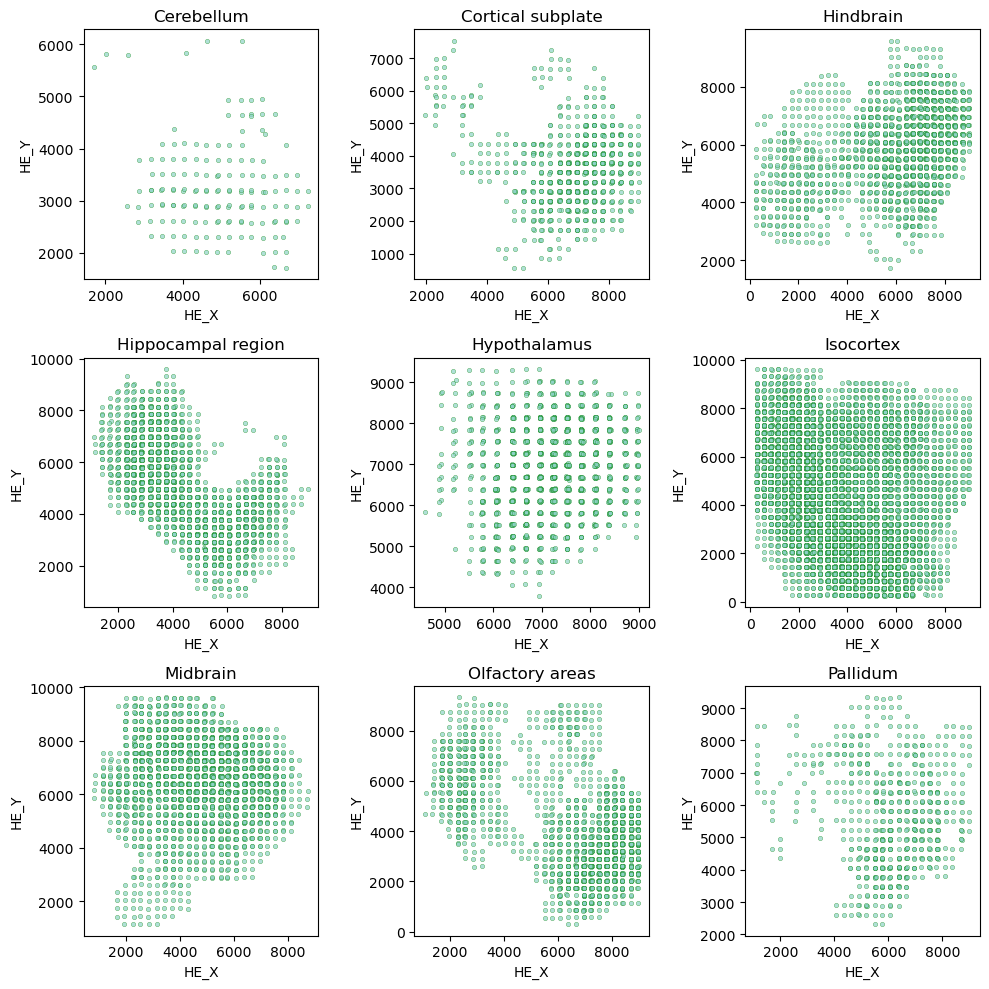

In [ ]:
fig = plt.figure(figsize=(10, 10))
sns.set_palette(sns.color_palette("Set3", 10))
for i, (name, group) in enumerate(metadata.groupby('ABA_parent')):
    if i + 1 > 9:
        break
    ax = fig.add_subplot(3, 3, i+1)
    g = sns.scatterplot(data=group, x='HE_X', y='HE_Y', ax=ax, s=10, edgecolor='green', linewidth=0.3, alpha=0.7)
    g.set_title(name)
plt.tight_layout()
plt.show()

The Isocortex, Midbrain, Hippocampus, and Hindbrain regions seem to be well represented in this dataset moreso than other regions. This may point to possible data imbalance.

### Ingest the raw counts

Previously we loaded in the metadata. Using anndata, we can ingest both metadata and raw data simultaneously to shed insight into each sample. Although there is a pre-normalized set available for training, let's analyze the raw counts to see what sort of initial data we are working with.

In [ ]:
raw_data_file = 'GSE147747_expr_raw_counts_table.tsv'
raw_counts = pd.read_csv(raw_data_file, sep='\t', index_col=0)

In [ ]:
raw_counts.head(3)

Gnai3  Cdc45  Scml2  Apoh  Narf  Cav2  Klf6  Scmh1  Cox5a  \
02A_15.8x13.04       0      0      0     0     0     0     0      0      0   
02A_18.75x13.07      0      0      0     0     0     1     0      0      1   
02A_16.74x13.07      0      0      0     0     0     0     1      0      0   

                 Tbx2  ...  Gm17056  Platr19  Olfr457  Defa2  Olfr628  \
02A_15.8x13.04      0  ...        0        0        0      0        0   
02A_18.75x13.07     0  ...        0        0        0      0        0   
02A_16.74x13.07     0  ...        0        0        0      0        0   

                 Gm16982  Mir155hg  X6430562O15Rik  Olfr1386  RP24.502E20.6  
02A_15.8x13.04         0         0               0         0              0  
02A_18.75x13.07        0         0               0         0              0  
02A_16.74x13.07        0         0               0         0              0  

[3 rows x 23371 columns]

In [ ]:
raw_counts.shape

(34103, 23371)

##### Convert raw counts to anndata format

In [ ]:
adata = ad.AnnData(X=raw_counts.values, obs=metadata, var=pd.DataFrame(index=raw_counts.T.index))

In [ ]:
adata.chunk_X(5)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
adata.var_names_make_unique()

In [ ]:
adata.var_names

Index(['Gnai3', 'Cdc45', 'Scml2', 'Apoh', 'Narf', 'Cav2', 'Klf6', 'Scmh1',
       'Cox5a', 'Tbx2',
       ...
       'Gm17056', 'Platr19', 'Olfr457', 'Defa2', 'Olfr628', 'Gm16982',
       'Mir155hg', 'X6430562O15Rik', 'Olfr1386', 'RP24.502E20.6'],
      dtype='object', length=23371)

In [ ]:
adata.obs_names

Index(['01A_13.26x27.17', '01A_13.28x28.21', '01A_14.27x31.3',
       '01A_14.28x27.2', '01A_14.28x29.25', '01A_14.29x30.29',
       '01A_14.32x24.19', '01A_14.32x26.21', '01A_14.33x25.2',
       '01A_14.3x28.21',
       ...
       '40B_5.93x24.07', '40B_5.95x26.09', '40B_6.87x20.11', '40B_6.93x21.08',
       '40B_6.94x22.07', '40B_6.95x24.09', '40B_6.95x25.1', '40B_6.96x23.09',
       '40B_7.9x22.06', '40B_7.9x23.1'],
      dtype='object', length=34103)

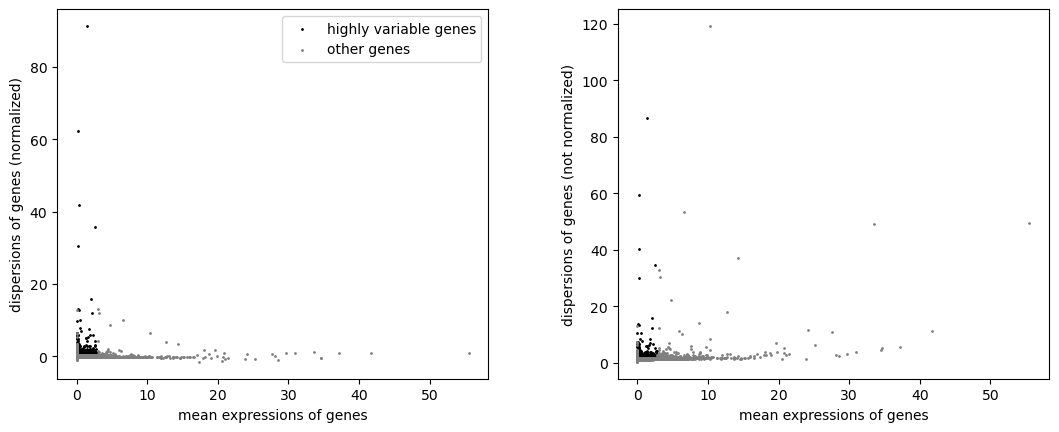

In [ ]:
sc.pp.recipe_seurat(adata, plot=True)

This plot shows that there's a small subsample of genes that are highly variable. We may not need to process all ~30K genes and can reduce the dimensionality to a select bunch. This will greatly reduce training overhead.

In [ ]:
output_name = "brain_data_raw"
output_file = output_name + ".h5ad"
adata.write(output_file, compression="gzip", as_dense=["X"])

In [ ]:
adata.var.sort_values(by='n_cells',ascending=False)

n_cells      mean       std
Gstp1             30008  1.143745  0.591873
Slc38a2           29597  1.113166  0.586028
Olig1             29277  1.115529  0.646579
Bend6             29264  1.130926  0.617159
Impact            29174  1.118836  0.617325
...                 ...       ...       ...
X2810417H13Rik      405  0.009057  0.089129
Chrnb4              368  0.007722  0.080375
X1700001C02Rik      366  0.008068  0.083786
Dbh                 339  0.008693  0.103866
Slc6a2              191  0.005568  0.084804

[373 rows x 3 columns]

Clearly, we can see there's a drastic drop in relevant genes from ~30K to over 300.

In [ ]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=200, subset=True) # if you didn't apply the recipe

In [ ]:
adata.var

n_cells      mean       std  highly_variable     means  \
Ngfr               1207  0.026409  0.150223             True  3.852919   
Ccnd2             19254  0.532736  0.544561             True  0.592285   
Th                 1915  0.044336  0.212079             True  4.022123   
Dbh                 339  0.008693  0.103866             True  4.152452   
Folr1              1719  0.041082  0.201597             True  3.969935   
...                 ...       ...       ...              ...       ...   
X1700001C02Rik      366  0.008068  0.083786             True  4.582599   
Tmem72              674  0.015507  0.119404             True  4.330497   
Ccdc153            1080  0.026216  0.159725             True  4.088594   
Gabra6             1432  0.041705  0.219346             True  3.732554   
Slc6a4              489  0.014040  0.133753             True  4.314638   

                dispersions  dispersions_norm  
Ngfr               9.658330         -0.079039  
Ccnd2              2.850744          2.059094  
Th                 9.789802          0.512812  
Dbh                9.853273          1.266226  
Folr1              9.757905          0.134190  
...                     ...               ...  
X1700001C02Rik     9.838719          1.812030  
Tmem72             9.797855          0.391843  
Ccdc153            9.734757         -0.140574  
Gabra6             9.626136          0.076993  
Slc6a4             9.866274          1.580612  

[200 rows x 7 columns]

<AxesSubplot: xlabel='n_cells', ylabel='dispersions'>

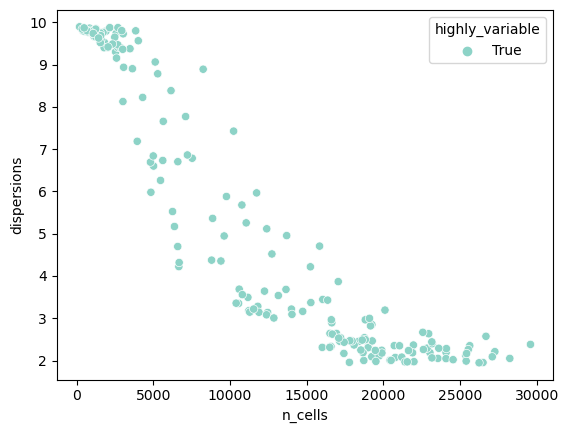

In [ ]:
# in how many cells did the gene appear
sns.scatterplot(data=adata.var, x='n_cells', y='dispersions', hue='highly_variable', )

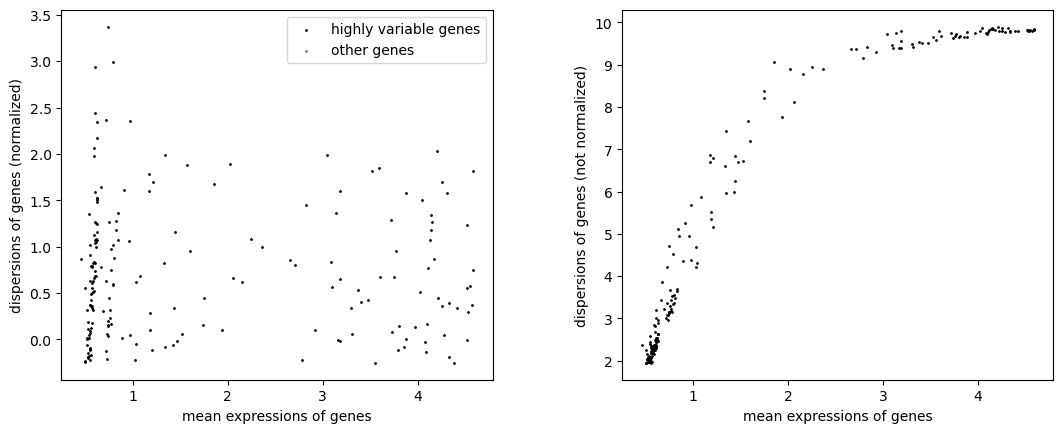

In [ ]:
sc.pl.highly_variable_genes(adata)

Now drilling down within the 300 genes into a safe sample of 200 genes, we can see a clean non-linear distribution of variable genes. The stock normalization seems to be messing up the distribution, so we may want to consider the pre-normalized set instead so the distribution is preserved.

In [ ]:
adata.var.sort_values(by='dispersions',ascending=False).head(3)

n_cells      mean       std  highly_variable     means  dispersions  \
Slc6a2      191  0.005568  0.084804             True  4.203882     9.892469   
Hcrt       2694  0.074730  0.311754             True  4.044514     9.872823   
Slc6a3     2159  0.051418  0.252043             True  4.254130     9.872685   

        dispersions_norm  
Slc6a2          2.035746  
Hcrt            1.498297  
Slc6a3          1.691993

In [ ]:
adata.var.sort_values(by='n_cells',ascending=False).head(3)

n_cells      mean       std  highly_variable     means  dispersions  \
Slc38a2    29597  1.113166  0.586028             True  0.457850     2.382091   
Adarb1     28248  1.043805  0.653958             True  0.517018     2.050942   
Pde1b      27273  1.004132  0.706304             True  0.561276     2.211045   

         dispersions_norm  
Slc38a2          0.862043  
Adarb1           0.016206  
Pde1b            0.425148

In [ ]:
adata.X.shape

(34056, 200)

##### Histogram of top highly variable genes

In [ ]:
top_genes_by_numcells = adata.var.loc[adata.var.index.isin(adata.var.sort_values(by='n_cells',ascending=False).head(3).index)]
top_genes_by_dispersion = adata.var.loc[adata.var.index.isin(adata.var.sort_values(by='dispersions',ascending=False).head(3).index)]

Text(0, 0.5, 'Gene')

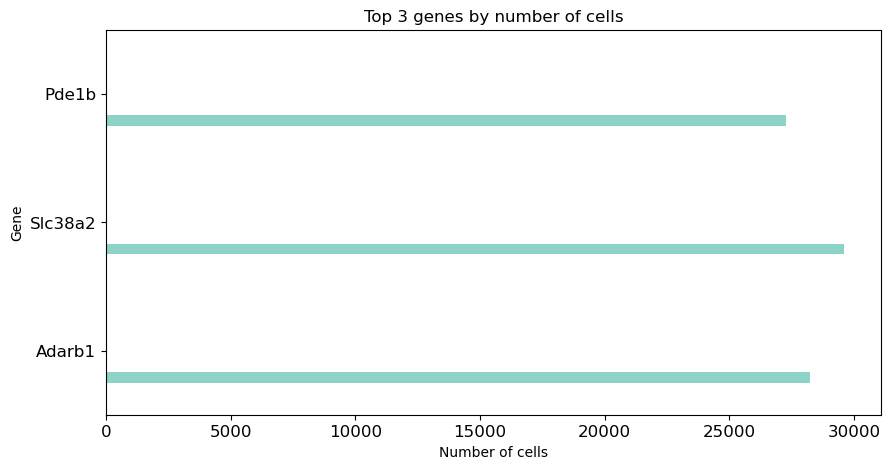

In [ ]:
ax = top_genes_by_numcells.plot(
    kind='barh', 
    title='Top 3 genes by number of cells', 
    legend=False, 
    figsize=(10,5), 
    rot=0, 
    fontsize=12
    )
ax.set_xlabel('Number of cells')
ax.set_ylabel('Gene')
# ax.set(xlim=[33000, 34060])

Text(0, 0.5, 'Gene')

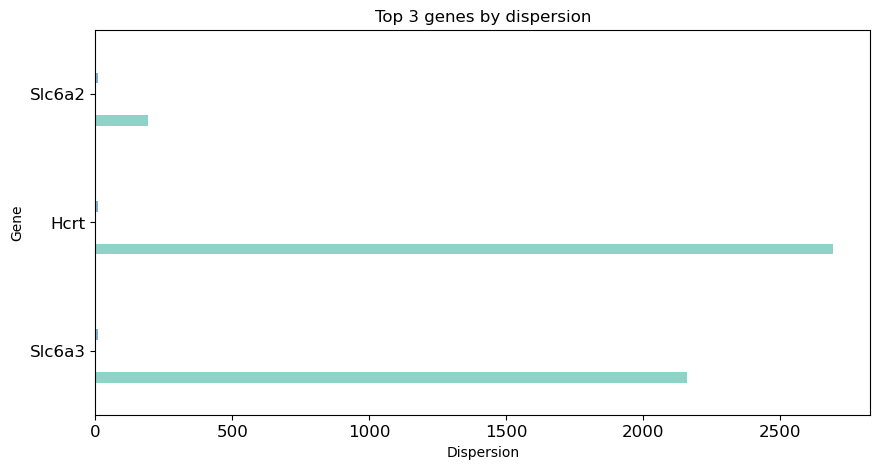

In [ ]:
ax = top_genes_by_dispersion.plot(
    kind='barh', 
    title='Top 3 genes by dispersion', 
    legend=False, 
    figsize=(10,5), 
    rot=0, 
    fontsize=12
    )
ax.set_xlabel('Dispersion')
ax.set_ylabel('Gene')

There is a drastic difference in dispersion of genes among cells. Of the top 3, only two are highly dispersed and the rest are minimally dispersed significantly.

In [ ]:
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=40, use_rep='X')
sc.tl.umap(adata)

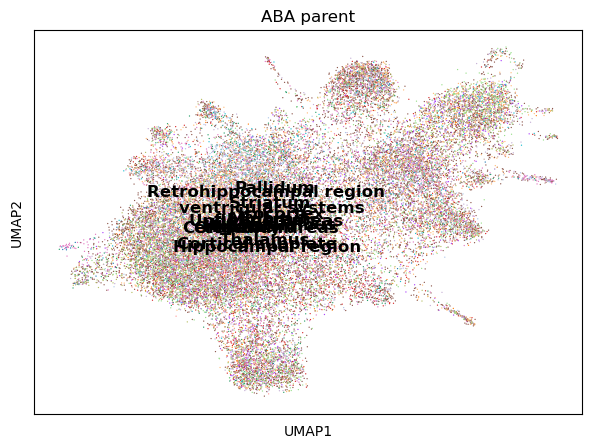

In [ ]:
sc.pl.scatter(adata, basis='umap', color='ABA_parent', legend_loc='on data', legend_fontsize=12, )

Using the stock target labels provided by the dataset, we can see an improper distribution of classes and a huge clump in the middle. We may consider distilling this target feature into better distributed bins.

In [ ]:
sc.tl.rank_genes_groups(adata, 'ABA_parent', method='wilcoxon', n_genes=adata.shape[1])

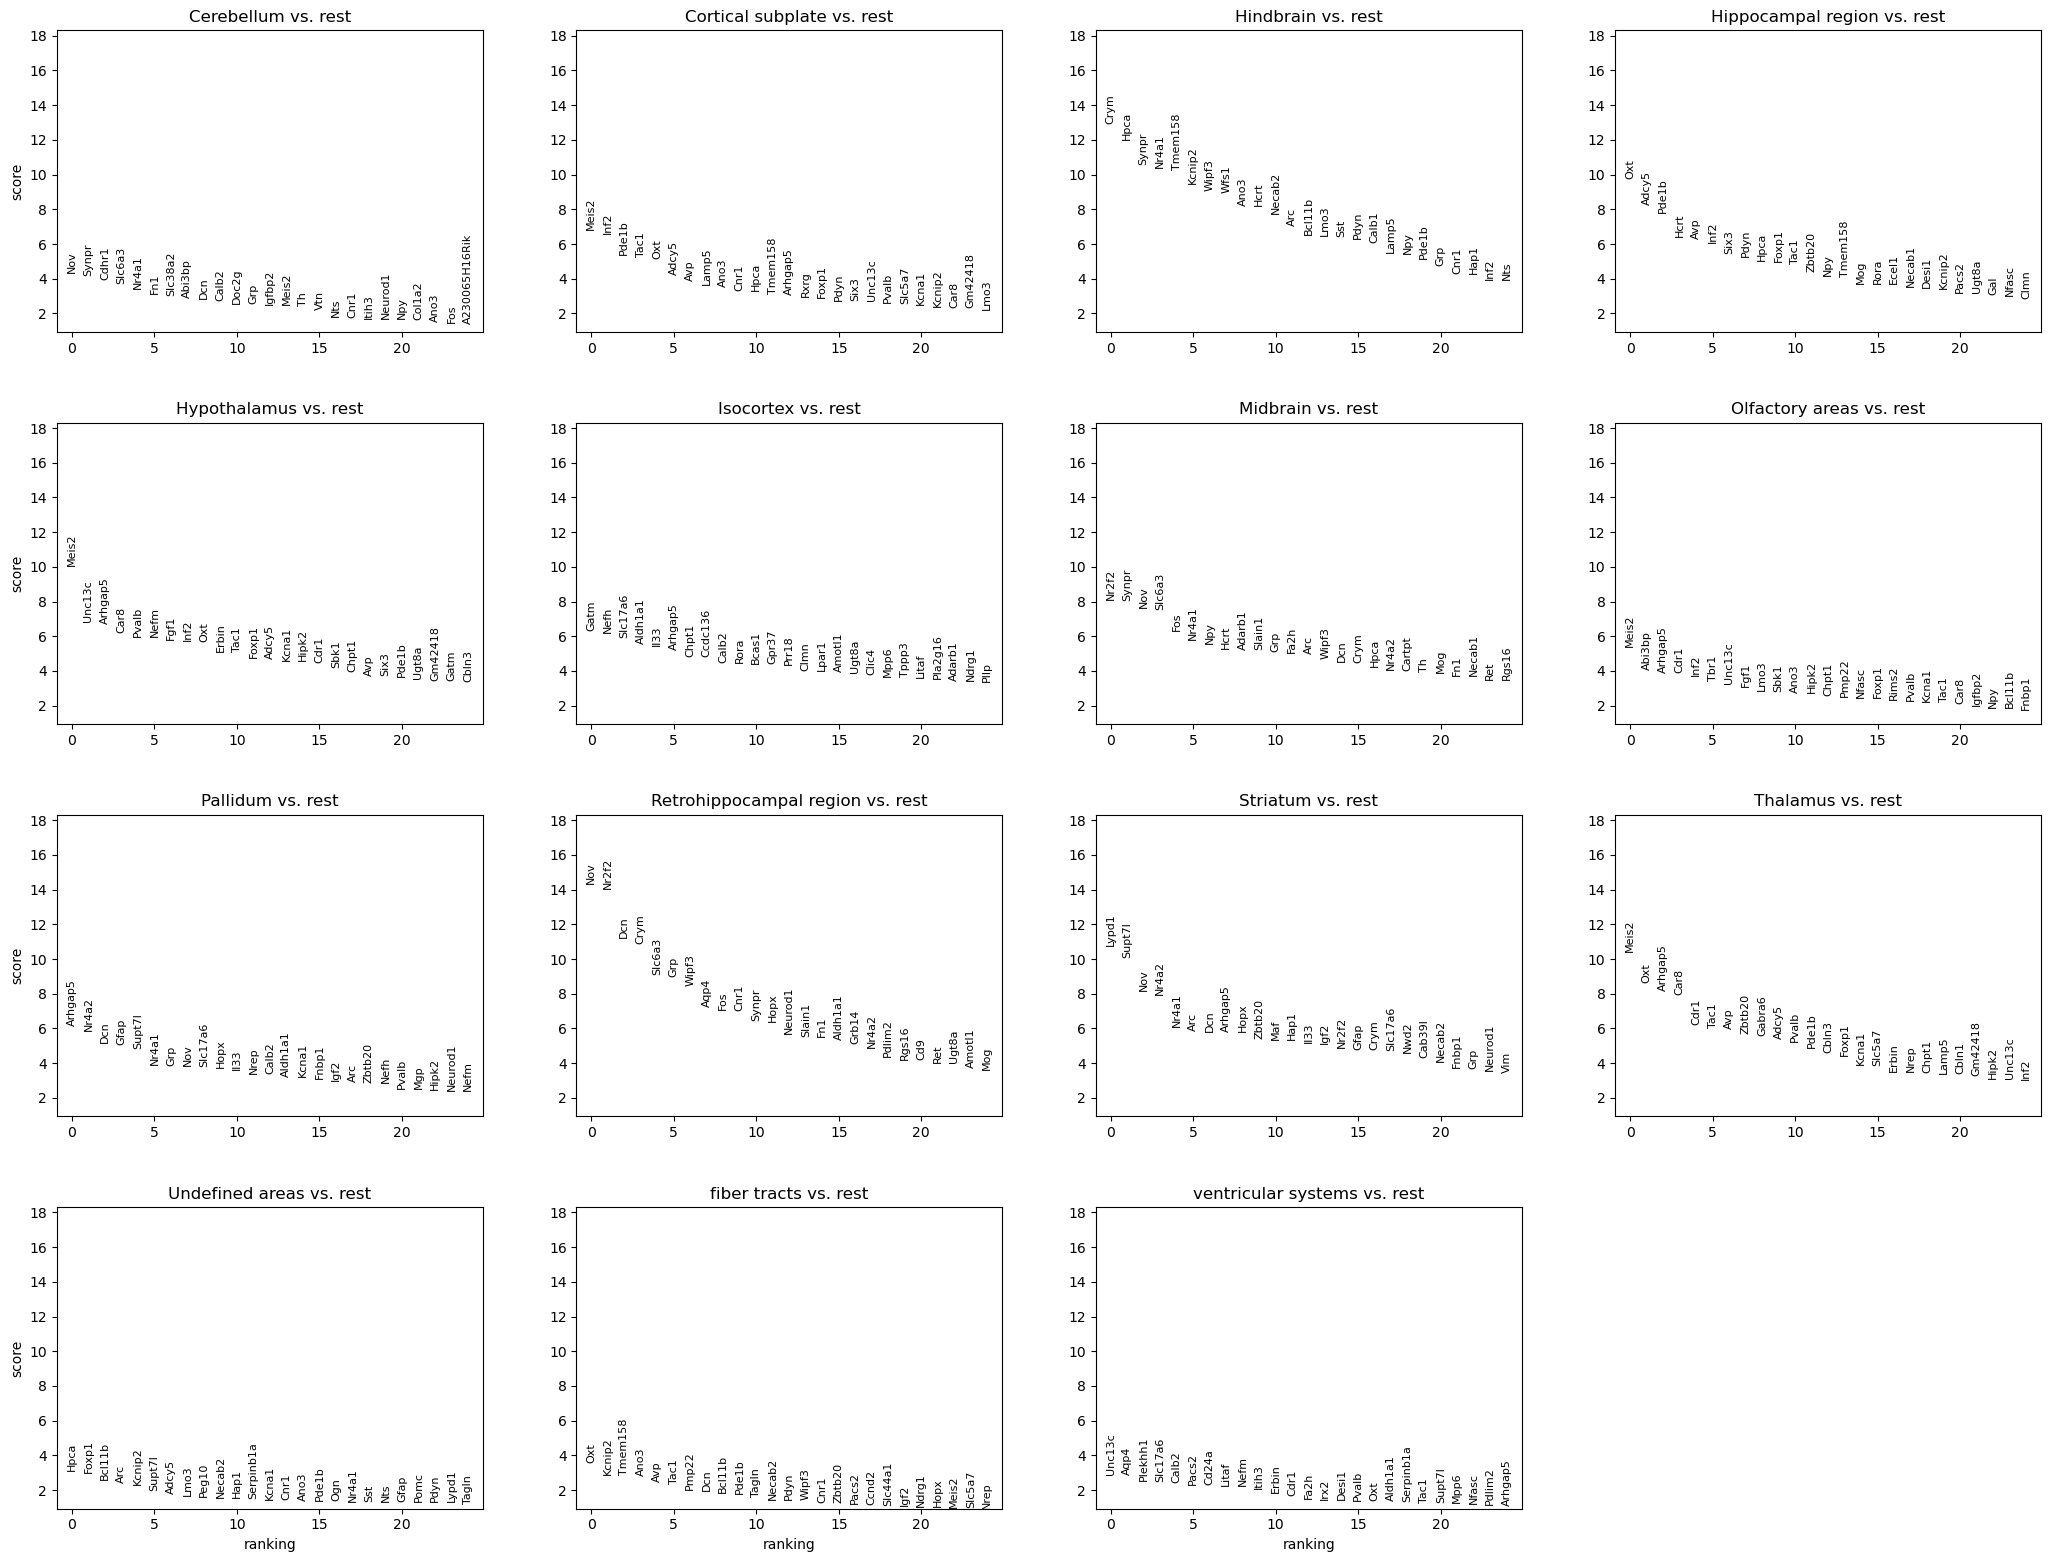

In [ ]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=True)

There seem to be some overlapping genes among the different brain regions.

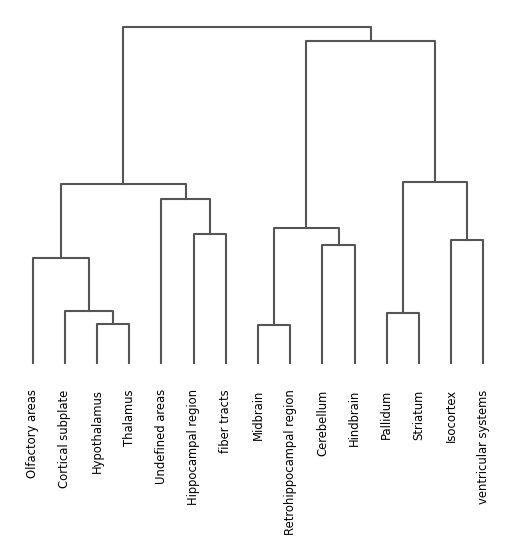

<AxesSubplot: >

In [ ]:
sc.tl.dendrogram(adata, groupby='ABA_parent', use_rep='X')
sc.pl.dendrogram(adata, groupby='ABA_parent')

Although there are many divisions of classes, I can see three main branches we can group the other subclasses in to allow for a better distribution of data.

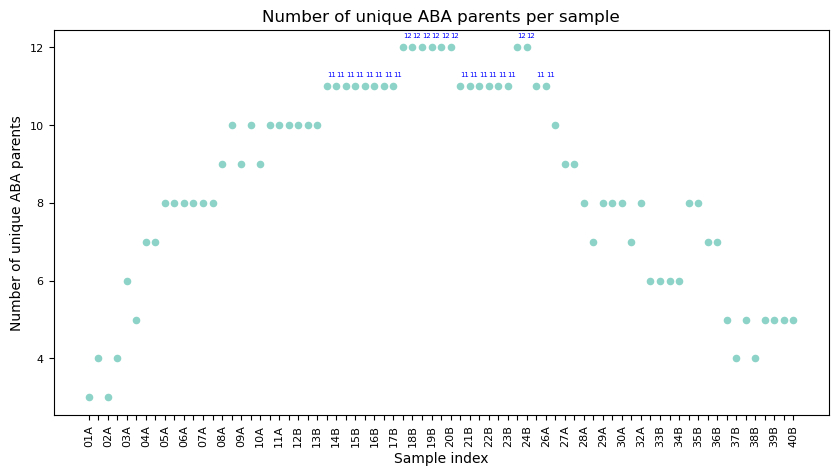

In [ ]:
v = adata.obs.groupby(['section_index'])['ABA_parent'].nunique()
ax = v.reset_index().plot(
    kind='scatter', 
    x='section_index', 
    y='ABA_parent', 
    figsize=(10,5), 
    title='Number of unique ABA parents per sample', 
    fontsize=8,
    xlabel='Sample index', 
    ylabel='Number of unique ABA parents', 
    rot=90
)

xticks = ax.get_xticklabels()
for i, xtick in enumerate(xticks):
    if i % 2 != 0:
        xtick.set_visible(False)
xticks = [x.get_text() for x in xticks]

holdout = []

c = ax.collections[0]
cs = c.get_offsets().tolist()
for i, txt in enumerate(v.values):
    if txt > 10:
        holdout.append(xticks[i])
        ax.annotate(txt, (cs[i][0], cs[i][1]), fontsize=5, color='blue', xytext=(0,10), textcoords="offset pixels")




This is a very important plot because it allows us to identify the optimal samples to isolate for a validation set.

In [ ]:
# randomly select 7 samples from the holdout set
h = np.random.choice(holdout, 7, replace=False)
h

array(['21A', '15B', '16B', '22B', '14A', '16A', '17B'], dtype='<U3')

In [ ]:
val_set = adata[adata.obs['section_index'].isin(h)]
current_set = adata[~adata.obs['section_index'].isin(h)]

#### Export data to H5AD format for ingestion into GNN

In [ ]:
adata.obs.shape

(34056, 15)

In [ ]:
dataset = pd.read_csv('GSE147747_expr_normalized_table.tsv', sep='\t', index_col=0)

In [ ]:
metadata = pd.read_csv('GSE147747_meta_table.tsv', sep='\t', index_col=0)

In [ ]:
metadata.reset_index(inplace=True)
dataset.reset_index(inplace=True)

# rename the index column
dataset.rename(columns={'index': 'sample_idx'}, inplace=True)
metadata.rename(columns={'index': 'sample_idx'}, inplace=True)

# find the intersection of the two dataframes 
common_genes = list(set(dataset.sample_idx).intersection(set(metadata.sample_idx)))

# filter metadata by common genes
metadata = metadata[metadata.sample_idx.isin(common_genes)]

metadata.set_index('sample_idx', inplace=True)
dataset.set_index('sample_idx', inplace=True)

adata = ad.AnnData(X=dataset.values, obs=metadata, var=pd.DataFrame(index=dataset.T.index))

In [ ]:
# the paper provides the list of genes that are differentially expressed

with open('../data/top_genes_list.txt') as f:
    genes = f.readlines()

genes = [x.strip() for x in genes]

# only keep the genes in adata that are in the list
adata = adata[:, adata.var.index.isin(genes)]

In [ ]:
# group ABA parents from dataset into cerebellum/other, cerebrum, and brainstem

classes = adata.obs['ABA_parent'].unique()
for item in classes:
    print(item)

Isocortex
Olfactory areas
fiber tracts
ventricular systems
Cortical subplate
Striatum
Pallidum
Undefined areas
Hypothalamus
Hippocampal region
Thalamus
Retrohippocampal region
Midbrain
Hindbrain
Cerebellum


Acording to the ABA Ontology (as referenced in the research paper), we can group the subclasses into 3 main categories: Cerebellum/Other, Cerebrum, and Brain Stem.

In [ ]:
new_parents = {
    'Cerebellum/Other':['ventricular systems', 'fiber tracts', 'Cerebellum', 'Undefined areas'],
    'Cerebrum':['Hippocampal region', 'Retrohippocampal region', 'Isocortex', 'Cortical subplate', 'Olfactory areas', 'Striatum', 'Pallidum'],
    'Brain Stem':['Midbrain', 'Hindbrain', 'Hypothalamus', 'Thalamus']
}

# create new column in dataset.obs
adata.obs['new_parent'] = adata.obs['ABA_parent'].apply(lambda x: [k for k,v in new_parents.items() if x in v][0])

In [ ]:
adata.shape

(34053, 232)

In [ ]:
adata.obs['new_parent'].value_counts()

Cerebrum            21655
Brain Stem           8584
Cerebellum/Other     3814
Name: new_parent, dtype: int64

There still exists a class imbalance, but it is not as severe as before.

In [ ]:
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=40, use_rep='X')
sc.tl.umap(adata)

In [ ]:
sc.pl.scatter(adata, basis='umap', color='new_parent', legend_loc='on data', legend_fontsize=12, )

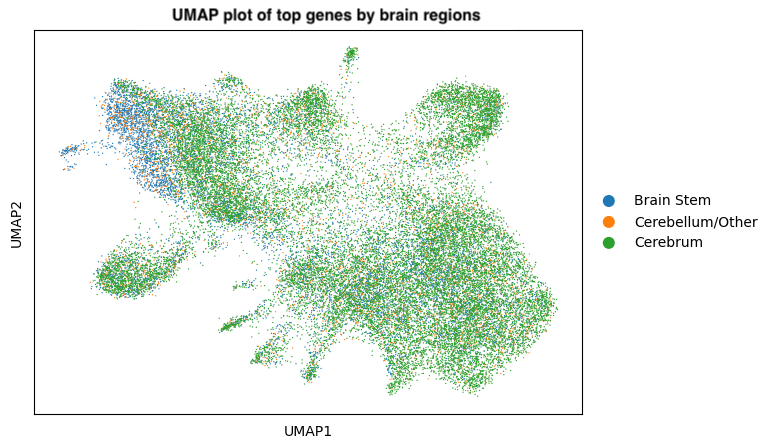

Now there is a better separation of classes, however the high imbalance reflected by the Cerebrum is apparent. We will need to account for this during training.

## 4. Design

I am splitting the data using a 70/20/10 split, where 10% of the total samples will be used as a holdout set. Since there are 75 samples from which the data was curated, I am using 7 samples as part of my validation set. This is so that points are contextualized based on their sample of origin as opposed to a generic random point assignment.

The experiments are divisioned by baseline experiments, comparative experiments, and supplemental experiments.

The baseline experiments include: logistic regression, neural network (without adherence to spatial information), random forest, and an xgboost classifier.

The comparative experiments include: graph convolutional network, spatial kernel neural operator, spatial kernel neural operator with gcn layers, and a graph kernel neural operator.

For preparing the data for graph learning, the only caveat is data loading. I am using PyTorch Geometric to package the data samples as grid-like graph representations. From there, it is just straightforward training of data using PyTorch.

The supplemental experiments include: graph attention network, graph sage network, and graph isomorphism network.

I am using accuracy and F1 scores as metrics to compare the performance against each model. The F1 score proves reliable in comparing performance as it is more robust in dealing with class imbalances.

### Split dataset into train, test, and validation sets

Instead of randomly splitting, we'll use the selected samples from the unique ABA parents per sample plot above to create a validation set of 10% of the total samples (about 7 samples).

In [ ]:
h = np.array(['23A', '20A', '26A', '39B', '21B', '18A', '04B'])
val_set = adata[adata.obs['section_index'].isin(h)]
current_set = adata[~adata.obs['section_index'].isin(h)]

In [ ]:
val_set

View of AnnData object with n_obs × n_vars = 3394 × 232
    obs: 'section_index', 'stereo_ML', 'stereo_DV', 'stereo_AP', 'HE_X', 'HE_Y', 'ABA_acronym', 'ABA_name', 'ABA_parent', 'nuclei_segmented', 'spot_radius', 'passed_QC', 'cluster_id', 'cluster_name', 'new_parent'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(current_set.X, current_set.obs['new_parent'], test_size=0.3, random_state=42, stratify=current_set.obs['new_parent'], shuffle=True)
X_val = val_set.X
y_val = val_set.obs['new_parent']

We'll save the objects for efficient loading in case of notebook crashing.

In [ ]:
# save the class weights using pytorch's class weights
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = torch.FloatTensor(class_weights)
torch.save(class_weights, 'class_weights.pt')

In [ ]:
# save adata
output_name = "brain_data_200"
output_file = output_name + ".h5ad"
adata.write(output_file, compression="gzip", as_dense=["X"])

# save current set
output_name = "brain_data_200_train"
output_file = output_name + ".h5ad"
current_set.write(output_file, compression="gzip", as_dense=["X"])

# save validation set
output_name = "brain_data_200_val"
output_file = output_name + ".h5ad"
val_set.write(output_file, compression="gzip", as_dense=["X"])

In [ ]:
print("X train: ", X_train.shape)
print("X test: ", X_test.shape)
print("y train: ", y_train.shape)
print("y test: ", y_test.shape)
print("X val: ", X_val.shape)
print("y val: ", y_val.shape)

print("Percent of samples in validation set: ", (val_set.shape[0] / X_train.shape[0]) * 100)

X train:  (21461, 232)
X test:  (9198, 232)
y train:  (21461,)
y test:  (9198,)
X val:  (3394, 232)
y val:  (3394,)
Percent of samples in validation set:  15.814733702996135


In [ ]:
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({'Cerebrum': 13712, 'Brain Stem': 5345, 'Cerebellum/Other': 2404})
Testing target statistics: Counter({'Cerebrum': 5877, 'Brain Stem': 2291, 'Cerebellum/Other': 1030})


### Baseline Models

#### Build a Logistic Regression Model

In [ ]:
clf = LogisticRegression(random_state=0, max_iter=1000, class_weight='balanced').fit(X_train, y_train) #, class_weight='balanced'

In [ ]:
# predict on validation set
y_pred_val = clf.predict(X_val)

# accuracy on validation set
evaluate_predictions(y_pred_val, y_val, val=True)

# predict on test set
y_pred = clf.predict(X_test)

# accuracy on test set
evaluate_predictions(y_pred, y_test)

Validation accuracy: 40.276959340011786
Test accuracy: 48.9562948467058
Classification Report: 
                  precision    recall  f1-score   support

      Brain Stem       0.40      0.51      0.45      2291
Cerebellum/Other       0.13      0.30      0.18      1030
        Cerebrum       0.76      0.52      0.61      5877

        accuracy                           0.49      9198
       macro avg       0.43      0.44      0.42      9198
    weighted avg       0.60      0.49      0.52      9198



In [ ]:
le = LabelEncoder()
le.fit(adata.obs['new_parent'])

y_train = le.transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

#### Build a fully connected neural network --> pytorch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(232, 256), # 200 --> 64/maybe 128 across --> 15
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork()#.to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=232, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=3, bias=True)
    (5): Softmax(dim=1)
  )
)


In [ ]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X=torch.tensor(X)
        self.Y=torch.tensor(y)
        self.len=self.X.shape[0]
    def __getitem__(self,index):      
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len

traindata=Data(X_train, y_train)
train_loader=DataLoader(dataset=traindata,batch_size=64)

In [ ]:
class_weights = torch.load('class_weights.pt')
weights = torch.tensor(class_weights)

loss_fn=nn.CrossEntropyLoss(weight=weights) #weight=class_weights
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
learner=Learner(model,train_loader,optimizer,loss_fn,device=device)

learner.reset_all_weights()
learner.run(epochs=300)


Epoch 1
-------------------------------
loss: 1.097017  [    0/21461]
Train accuracy: 51.5625
loss: 1.094633  [ 6400/21461]
Train accuracy: 51.5625
loss: 1.077320  [12800/21461]
Train accuracy: 64.0625
loss: 1.084740  [19200/21461]
Train accuracy: 62.5
Epoch 2
-------------------------------
loss: 1.061959  [    0/21461]
Train accuracy: 70.3125
loss: 1.077496  [ 6400/21461]
Train accuracy: 57.8125
loss: 1.054870  [12800/21461]
Train accuracy: 64.0625
loss: 1.069218  [19200/21461]
Train accuracy: 60.9375
Epoch 3
-------------------------------
loss: 1.041292  [    0/21461]
Train accuracy: 68.75
loss: 1.065759  [ 6400/21461]
Train accuracy: 57.8125
loss: 1.048675  [12800/21461]
Train accuracy: 64.0625
loss: 1.059721  [19200/21461]
Train accuracy: 56.25
Epoch 4
-------------------------------
loss: 1.032216  [    0/21461]
Train accuracy: 70.3125
loss: 1.059174  [ 6400/21461]
Train accuracy: 57.8125
loss: 1.042049  [12800/21461]
Train accuracy: 64.0625
loss: 1.054272  [19200/21461]
Train a

In [ ]:
y_pred_val = learner.model(torch.tensor(X_val)).argmax(1).detach().numpy()
evaluate_predictions(y_pred_val, y_val, val=True)

# validate on test set
# learner.data_loader = test_loader
y_pred_test = learner.model(torch.tensor(X_test)).argmax(1).detach().numpy()
evaluate_predictions(y_pred_test, y_test, val=False)


Validation accuracy: 56.54095462581026
Test accuracy: 61.41552511415526
Classification Report: 
              precision    recall  f1-score   support

           0       0.49      0.31      0.38      2291
           1       0.13      0.10      0.11      1030
           2       0.70      0.82      0.75      5877

    accuracy                           0.61      9198
   macro avg       0.44      0.41      0.41      9198
weighted avg       0.58      0.61      0.59      9198



The Pytorch MLP was on par with the basic Logistic Regressor in terms of accuracy.

#### Build a Random Forest Classifier

In [ ]:
brf = RandomForestClassifier(class_weight='balanced', n_jobs=-1, n_estimators=1000, max_depth=15)
brf.fit(X_train, y_train)

y_pred = brf.predict(X_test)
evaluate_predictions(y_pred, y_test, val=False)

Test accuracy: 68.04740160904544
Classification Report: 
              precision    recall  f1-score   support

           0       0.55      0.40      0.46      2291
           1       0.00      0.00      0.00      1030
           2       0.71      0.91      0.80      5877

    accuracy                           0.68      9198
   macro avg       0.42      0.44      0.42      9198
weighted avg       0.59      0.68      0.62      9198



<AxesSubplot: >

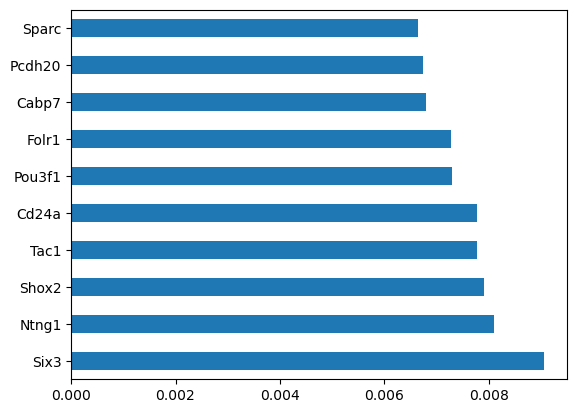

In [ ]:
feat_importances = pd.Series(brf.feature_importances_, index=adata.var_names)
feat_importances.sort_values(ascending=False).nlargest(10).plot(kind='barh')

<BarContainer object of 25 artists>

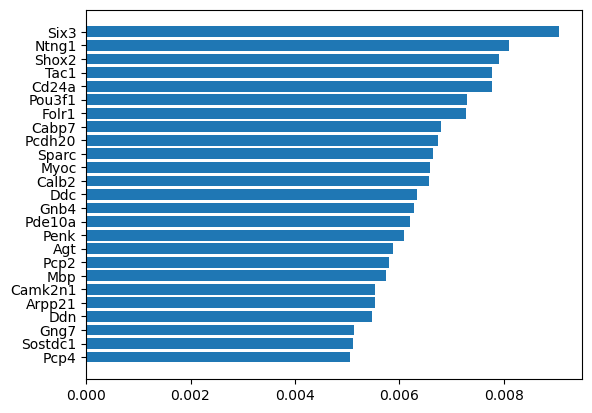

In [ ]:
sorted_idx = brf.feature_importances_.argsort()
# top 20 features
plt.barh(adata.var_names[sorted_idx][-25:], brf.feature_importances_[sorted_idx][-25:])

The Random Forest so far seems to be the baseline to beat with the highest balanced accuracy across all baselines.

#### Build a fully connected neural network --> sklearn

In [ ]:
def Mip(alpha=0.0001):
    return MLPClassifier (alpha=alpha, hidden_layer_sizes=(232,232), activation='relu', max_iter=300, random_state=0)

In [ ]:
Mip = Mip()
Mip.fit(X_train, y_train)

y_pred = Mip.predict(X_test)
evaluate_predictions(y_pred, y_test, val=False)

Test accuracy: 59.26288323548597
Classification Report: 
              precision    recall  f1-score   support

           0       0.42      0.40      0.41      2291
           1       0.12      0.09      0.10      1030
           2       0.71      0.75      0.73      5877

    accuracy                           0.59      9198
   macro avg       0.42      0.42      0.42      9198
weighted avg       0.57      0.59      0.58      9198



Strangely, the MLP classifier from sklearn is more accurate than the Pytorch flavor.

#### Train an XGBoost model

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [ ]:
y_pred = model.predict(X_test)
evaluate_predictions(y_pred, y_test, val=False)

Test accuracy: 68.44966297021091
Classification Report: 
              precision    recall  f1-score   support

           0       0.60      0.31      0.41      2291
           1       0.14      0.00      0.01      1030
           2       0.70      0.95      0.80      5877

    accuracy                           0.68      9198
   macro avg       0.48      0.42      0.41      9198
weighted avg       0.61      0.68      0.62      9198



The XGBoost classifier is slightly better than the Random Forest baseline and is capable of distinguishing against the other classes. It is the baseline to beat.

In [ ]:
%load_ext autoreload
%autoreload 2

#### Load dataset into PyG format

In [ ]:
from utils import *

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 300
lr = 0.001
weight_decay = 5e-4
dropout = 0.5

In [ ]:
class_weights = torch.load("class_weights.pt")
class_weights = class_weights.to(device)

In [ ]:
output_name = "brain_data_200_train"
output_file = output_name + ".h5ad"

cwd = os.getcwd()
url = "file://" + cwd + "/" + output_file
STDataset = spatial_transcriptomics_graph_dataset_factory(url,output_file,["HE_X", "HE_Y"], ["section_index"], target_key='new_parent')

In [ ]:
output_name_val = "brain_data_200_val"
output_file_val = output_name_val + ".h5ad"

url_val = "file://" + cwd + "/" + output_file_val
STDataset_val = spatial_transcriptomics_graph_dataset_factory(url_val,output_file_val,["HE_X", "HE_Y"], ["section_index"], target_key='new_parent')

The step below will check for two directories that are generated in the ingestion process: `brain_data_200_train` and `brain_data_200_val`. If you are re-running the graph network experiments within the notebook for the sake of reproducibility, the cell below will check for these directories if they exist already and rename them.

In [ ]:
if os.path.exists("brain_data_200_train_old"):
    # delete the previous old directory
    shutil.rmtree("brain_data_200_train_old")
    shutil.rmtree("brain_data_200_val_old")
# check if brain_data_200_train directory exists, and if so, rename it
if os.path.exists("brain_data_200_train"):
    shutil.move("brain_data_200_train", "brain_data_200_train_old")
    shutil.move("brain_data_200_val", "brain_data_200_val_old")

We'll need to manually tweak the radius transformation in order to preprocess the data to get it into a properly connected grid-like graph structure. This will be key for training.

In [ ]:
# find minimum distance between coordinates and set the radius accordingly
train_dataset = STDataset(output_name, pre_transform=tg.transforms.Compose([tg.transforms.RadiusGraph(500)]))
val_dataset = STDataset_val(output_name_val, pre_transform=tg.transforms.Compose([tg.transforms.RadiusGraph(500)]))

Processing...


Graph 01A has 150 nodes, 1044 edges, and 468 edge features.
Graph 01B has 197 nodes, 1410 edges, and 468 edge features.
Graph 02A has 240 nodes, 1752 edges, and 468 edge features.
Graph 02B has 218 nodes, 1584 edges, and 468 edge features.
Graph 03A has 269 nodes, 1972 edges, and 468 edge features.
Graph 03B has 273 nodes, 1978 edges, and 468 edge features.
Graph 04A has 286 nodes, 2088 edges, and 468 edge features.
Graph 05A has 361 nodes, 2670 edges, and 468 edge features.
Graph 05B has 357 nodes, 2632 edges, and 468 edge features.
Graph 06A has 393 nodes, 2918 edges, and 468 edge features.
Graph 06B has 402 nodes, 2954 edges, and 468 edge features.
Graph 07A has 488 nodes, 3636 edges, and 468 edge features.
Graph 07B has 461 nodes, 3420 edges, and 468 edge features.
Graph 08A has 381 nodes, 2814 edges, and 468 edge features.
Graph 08B has 470 nodes, 3494 edges, and 468 edge features.
Graph 09A has 491 nodes, 3592 edges, and 468 edge features.
Graph 09B has 511 nodes, 3772 edges, and

Done!
Processing...


Graph 04B has 326 nodes, 2398 edges, and 468 edge features.
Graph 18A has 575 nodes, 4286 edges, and 468 edge features.
Graph 20A has 555 nodes, 4146 edges, and 468 edge features.
Graph 21B has 576 nodes, 4296 edges, and 468 edge features.
Graph 23A has 574 nodes, 4278 edges, and 468 edge features.
Graph 26A has 548 nodes, 4066 edges, and 468 edge features.
Graph 39B has 240 nodes, 1672 edges, and 468 edge features.


Done!


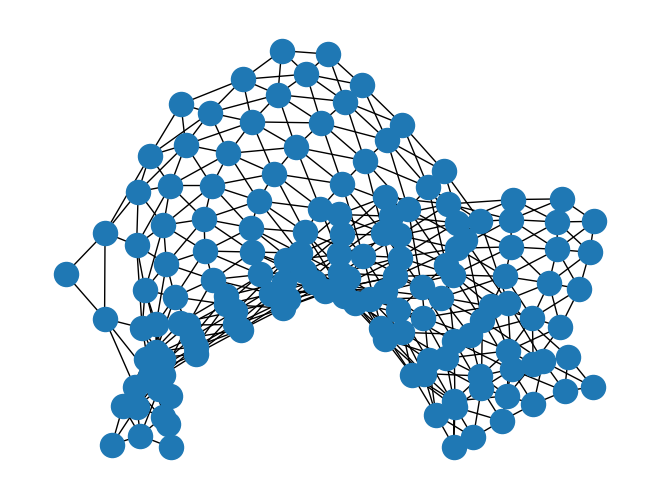

In [ ]:
import networkx as nx
g = tg.utils.to_networkx(train_dataset[0], to_undirected=True)
nx.draw(g)

In [ ]:
train_dataset.data

Data(x=[30659, 232], y=[30659], pos=[30659, 2], sample_name=[68], edge_index=[2, 225730], edge_attr=[225730, 468], train=[68])

In [ ]:
val_dataset.data

Data(x=[3394, 232], y=[3394], pos=[3394, 2], sample_name=[7], edge_index=[2, 25142], edge_attr=[25142, 468], train=[7])

In [ ]:
train_dataset[0].edge_index

tensor([[  1,   9,   3,  ..., 144, 134, 143],
        [  0,   0,   0,  ..., 149, 149, 149]])

In [ ]:
for batch in train_dataset:
    # set edge attr to [num_edges, num_edge_features]
    print(batch)
    break

Data(x=[150, 232], y=[150], pos=[150, 2], sample_name='01A', edge_index=[2, 1044], edge_attr=[1044, 468], train=[1])


In [ ]:
train_dataset.data.y

tensor([2, 2, 2,  ..., 0, 0, 0])

In [ ]:
# create a dataloader for the training set and validation set
val_loader = tg.data.DataLoader(val_dataset, batch_size=1, shuffle=True)

train_size = int(len(train_dataset) * 0.7)
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])

train_loader = tg.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = tg.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [ ]:
len(train_dataset.indices)

47

Just a couple of sanity checks:

In [ ]:
for batch in train_loader:
    print(batch)
    break

DataBatch(x=[506, 232], y=[506], pos=[506, 2], sample_name=[1], edge_index=[2, 3646], edge_attr=[3646, 468], train=[1], batch=[506], ptr=[2])


In [ ]:
for batch in test_loader:
    print(batch)
    break

DataBatch(x=[507, 232], y=[507], pos=[507, 2], sample_name=[1], edge_index=[2, 3774], edge_attr=[3774, 468], train=[1], batch=[507], ptr=[2])


In [ ]:
for batch in val_loader:
    print(batch)
    break

DataBatch(x=[575, 232], y=[575], pos=[575, 2], sample_name=[1], edge_index=[2, 4286], edge_attr=[4286, 468], train=[1], batch=[575], ptr=[2])


In [ ]:
train_loader.dataset.dataset.data.num_features

232

In [ ]:
train_loader.dataset.dataset.data.y.max().item() + 1

3

In [ ]:
train_loader.dataset.dataset.data.edge_attr

tensor([[1.6840e+00, 1.6840e+00, 0.0000e+00,  ..., 7.8574e+03, 3.4649e+03,
         7.5580e+03],
        [1.1516e+00, 0.0000e+00, 0.0000e+00,  ..., 7.8566e+03, 3.4649e+03,
         7.5580e+03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 7.5654e+03, 3.4649e+03,
         7.5580e+03],
        ...,
        [1.7011e+00, 1.8027e+00, 9.3709e-02,  ..., 6.1315e+03, 2.0123e+03,
         6.4301e+03],
        [1.5620e+00, 3.8759e-01, 1.2195e+00,  ..., 6.4286e+03, 2.0123e+03,
         6.4301e+03],
        [1.6244e+00, 1.5061e+00, 9.3842e-02,  ..., 6.7172e+03, 2.0123e+03,
         6.4301e+03]])

In [ ]:
# get number of features from train loader
num_features = train_loader.dataset.dataset.data.num_features
# get number of classes from train loader
num_classes = train_loader.dataset.dataset.data.y.max().item() + 1

### Comparative Experiments

#### Train a GCN

In [ ]:
model1 = GCN(num_features, num_classes).to(device)
optimizer1 = Adam(model1.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn=nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
learner=Learner(model1,train_loader,optimizer1,loss_fn,device=device)
learner.reset_all_weights()
learner.run(epochs=epochs)

Epoch 1
-------------------------------
loss: 1.919318  [    0/   47]
Train accuracy: 59.333333333333336
Train loss: 0.9702261686325073
Epoch 2
-------------------------------
loss: 0.915433  [    0/   47]
Train accuracy: 21.08843537414966
Train loss: 1.1169569492340088
Epoch 3
-------------------------------
loss: 0.756901  [    0/   47]
Train accuracy: 62.20472440944882
Train loss: 0.8982328772544861
Epoch 4
-------------------------------
loss: 0.787483  [    0/   47]
Train accuracy: 26.72897196261682
Train loss: 1.1689808368682861
Epoch 5
-------------------------------
loss: 1.150229  [    0/   47]
Train accuracy: 73.38551859099805
Train loss: 0.9339768886566162
Epoch 6
-------------------------------
loss: 0.766935  [    0/   47]
Train accuracy: 22.242990654205606
Train loss: 1.1604279279708862
Epoch 7
-------------------------------
loss: 1.159324  [    0/   47]
Train accuracy: 88.64970645792563
Train loss: 0.9090172648429871
Epoch 8
-------------------------------
loss: 0.81569

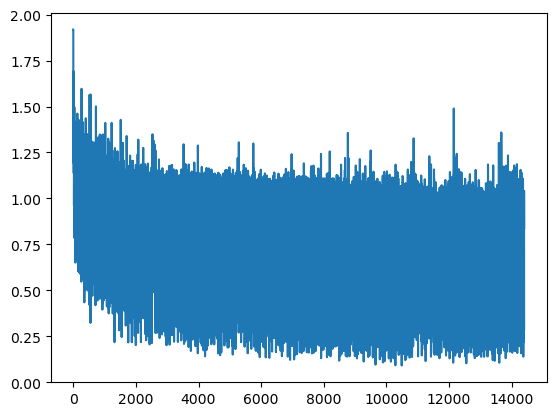

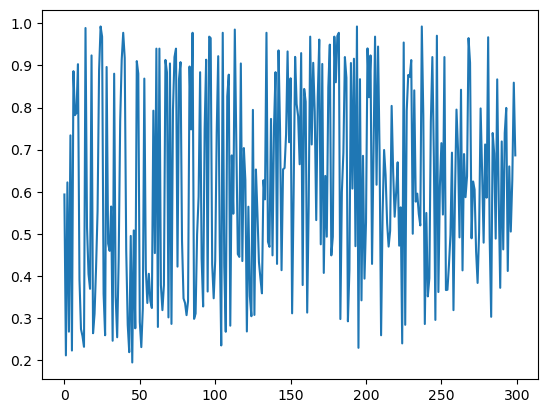

In [ ]:
import matplotlib.pyplot as plt

plt.plot(learner.losses)
plt.show()

plt.plot(learner.accuracies)
plt.show()

#### Train a Spatial Kernel

The SpatialKernel model uses three linear layers, wherein a gaussian kernel is computed and applied before each layer.

In [ ]:
model2 = SpatialKernel(train_loader.dataset.dataset.data.num_features, train_loader.dataset.dataset.data.y.max().item() + 1).to(device)
optimizer2 = Adam(model2.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn=nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
learner=Learner(model2,train_loader,optimizer2,loss_fn,device=device)
learner.reset_all_weights()
learner.run(epochs=epochs)

Epoch 1
-------------------------------
loss: 12625.455078  [    0/   47]
Train accuracy: 47.90794979079498
Train loss: 18165.880859375
Epoch 2
-------------------------------
loss: 14530.185547  [    0/   47]
Train accuracy: 52.3517382413088
Train loss: 7015.04296875
Epoch 3
-------------------------------
loss: 13163.628906  [    0/   47]
Train accuracy: 84.72505091649694
Train loss: 587.0570678710938
Epoch 4
-------------------------------
loss: 1517.837402  [    0/   47]
Train accuracy: 22.05607476635514
Train loss: 1644.2802734375
Epoch 5
-------------------------------
loss: 292.812683  [    0/   47]
Train accuracy: 92.0
Train loss: 26.7381534576416
Epoch 6
-------------------------------
loss: 1.132318  [    0/   47]
Train accuracy: 26.537216828478964
Train loss: 1.067573070526123
Epoch 7
-------------------------------
loss: 1.110441  [    0/   47]
Train accuracy: 67.19160104986877
Train loss: 1.0146507024765015
Epoch 8
-------------------------------
loss: 1.069764  [    0/   

#### Train a SpatialGCN

The SpatialGCN model combines both the SpatialKernel and GCN such that each layer is a GCNConv layer, and a gaussian kernel is computed before each convolutional layer.

In [ ]:
model3 = SpatialGCN(train_loader.dataset.dataset.data.num_features, train_loader.dataset.dataset.data.y.max().item() + 1).to(device)
optimizer3 = Adam(model3.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn=nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
learner=Learner(model3,train_loader,optimizer3,loss_fn,device=device)
learner.reset_all_weights()
learner.run(epochs=epochs)

Epoch 1
-------------------------------
loss: 287983.843750  [    0/   47]
Train accuracy: 66.12244897959184
Train loss: 7303.53076171875
Epoch 2
-------------------------------
loss: 13266.620117  [    0/   47]
Train accuracy: 92.0
Train loss: 4616.2353515625
Epoch 3
-------------------------------
loss: 13303.041992  [    0/   47]
Train accuracy: 33.396946564885496
Train loss: 20727.986328125
Epoch 4
-------------------------------
loss: 40367.894531  [    0/   47]
Train accuracy: 75.0
Train loss: 4496.86669921875
Epoch 5
-------------------------------
loss: 12892.789062  [    0/   47]
Train accuracy: 26.623376623376622
Train loss: 13509.9189453125
Epoch 6
-------------------------------
loss: 8211.290039  [    0/   47]
Train accuracy: 61.81229773462783
Train loss: 15890.0283203125
Epoch 7
-------------------------------
loss: 3569.386963  [    0/   47]
Train accuracy: 40.2834008097166
Train loss: 2558.6796875
Epoch 8
-------------------------------
loss: 21925.505859  [    0/   47]

#### Train a Graph PDE

In [ ]:
# train the GraphPDE model on the training set 
model4 = GraphPDE(
    in_width=num_features,
    # width_node=train_loader.dataset.dataset.data.y.max().item() + 1,
    depth=6,
    ker_in=468,
    width_kernel=64,
    out_width=num_classes,
    ).to(device)
optimizer4 = torch.optim.Adam(model4.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
learner=Learner(model4,train_loader,optimizer4,loss_fn,device=device)
learner.reset_all_weights()
learner.run(epochs=epochs)

Epoch 1
-------------------------------
loss: 191.331772  [    0/   47]
Train accuracy: 61.224489795918366
Train loss: 1.1348108053207397
Epoch 2
-------------------------------
loss: 1.229525  [    0/   47]
Train accuracy: 49.330357142857146
Train loss: 1.2406097650527954
Epoch 3
-------------------------------
loss: 1.027549  [    0/   47]
Train accuracy: 62.02290076335878
Train loss: 1.0174378156661987
Epoch 4
-------------------------------
loss: 1.024398  [    0/   47]
Train accuracy: 42.018348623853214
Train loss: 1.0643953084945679
Epoch 5
-------------------------------
loss: 0.971147  [    0/   47]
Train accuracy: 41.61490683229814
Train loss: 1.286692500114441
Epoch 6
-------------------------------
loss: 0.845220  [    0/   47]
Train accuracy: 75.26881720430107
Train loss: 0.9406515955924988
Epoch 7
-------------------------------
loss: 0.893311  [    0/   47]
Train accuracy: 66.51017214397497
Train loss: 0.9687356352806091
Epoch 8
-------------------------------
loss: 0.910

### Supplementary benchmarks

#### Train a Graph Attention Network

In [ ]:
# train the GraphPDE model on the training set 
model5 = GAT(
    dim_in=num_features,
    dim_h=6,
    dim_out=num_classes
    ).to(device)
optimizer5 = torch.optim.Adam(model5.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
learner=Learner(model5,train_loader,optimizer5,loss_fn,device=device)
learner.reset_all_weights()
learner.run(epochs=epochs)

Epoch 1
-------------------------------
loss: 2.346036  [    0/   47]
Train accuracy: 43.973214285714285
Train loss: 1.1408156156539917
Epoch 2
-------------------------------
loss: 1.143993  [    0/   47]
Train accuracy: 85.0415512465374
Train loss: 0.9323246479034424
Epoch 3
-------------------------------
loss: 0.947993  [    0/   47]
Train accuracy: 34.82142857142857
Train loss: 1.1493345499038696
Epoch 4
-------------------------------
loss: 0.795124  [    0/   47]
Train accuracy: 50.39525691699605
Train loss: 1.1327611207962036
Epoch 5
-------------------------------
loss: 1.069028  [    0/   47]
Train accuracy: 87.33333333333333
Train loss: 0.7558183073997498
Epoch 6
-------------------------------
loss: 1.183349  [    0/   47]
Train accuracy: 50.19762845849802
Train loss: 1.1966941356658936
Epoch 7
-------------------------------
loss: 1.368270  [    0/   47]
Train accuracy: 81.26272912423626
Train loss: 0.9807095527648926
Epoch 8
-------------------------------
loss: 0.816220 

#### Train a GraphSAGE network

In [ ]:
model6 = GraphSAGE(
    dim_in=num_features,
    dim_h=6,
    dim_out=num_classes
    ).to(device)
optimizer6 = torch.optim.Adam(model6.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
learner=Learner(model6,train_loader,optimizer6,loss_fn,device=device)
learner.reset_all_weights()
learner.run(epochs=epochs)

Epoch 1
-------------------------------
loss: 1.408085  [    0/   47]
Train accuracy: 49.47589098532495
Train loss: 1.1063307523727417
Epoch 2
-------------------------------
loss: 1.109388  [    0/   47]
Train accuracy: 47.90794979079498
Train loss: 1.109192967414856
Epoch 3
-------------------------------
loss: 1.072272  [    0/   47]
Train accuracy: 67.4364896073903
Train loss: 1.099256992340088
Epoch 4
-------------------------------
loss: 1.109166  [    0/   47]
Train accuracy: 0.0
Train loss: 1.135683536529541
Epoch 5
-------------------------------
loss: 1.135972  [    0/   47]
Train accuracy: 94.0
Train loss: 1.0554510354995728
Epoch 6
-------------------------------
loss: 1.104418  [    0/   47]
Train accuracy: 52.3517382413088
Train loss: 1.111854076385498
Epoch 7
-------------------------------
loss: 1.101783  [    0/   47]
Train accuracy: 90.02770083102493
Train loss: 1.0597225427627563
Epoch 8
-------------------------------
loss: 1.101047  [    0/   47]
Train accuracy: 41

#### Train a Graph Isomorphism Network

In [ ]:
model7 = GIN(
    dim_in=num_features,
    dim_h=32,
    dim_out=num_classes
    ).to(device)
optimizer7 = torch.optim.Adam(model7.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
learner=Learner(model7,train_loader,optimizer7,loss_fn,device=device)
learner.reset_all_weights()
learner.run(epochs=epochs)

Epoch 1
-------------------------------
loss: 1.126405  [    0/   47]
Train accuracy: 62.091503267973856
Train loss: 1.110504388809204
Epoch 2
-------------------------------
loss: 1.115249  [    0/   47]
Train accuracy: 55.44041450777202
Train loss: 1.1137526035308838
Epoch 3
-------------------------------
loss: 1.112278  [    0/   47]
Train accuracy: 57.11462450592886
Train loss: 1.096122145652771
Epoch 4
-------------------------------
loss: 1.116451  [    0/   47]
Train accuracy: 27.788649706457925
Train loss: 1.0863920450210571
Epoch 5
-------------------------------
loss: 1.030766  [    0/   47]
Train accuracy: 19.71326164874552
Train loss: 1.3044521808624268
Epoch 6
-------------------------------
loss: 1.168918  [    0/   47]
Train accuracy: 58.79265091863517
Train loss: 0.8014925122261047
Epoch 7
-------------------------------
loss: 0.736070  [    0/   47]
Train accuracy: 75.91036414565826
Train loss: 0.6990121603012085
Epoch 8
-------------------------------
loss: 0.700481 

## 5. Diagnosis/Evaluation

#### Evaluation: GCN

In [ ]:
evaluate_predictions(val_loader, model1, val=True)
evaluate_predictions(test_loader, model1)

Validation accuracy: 32.85209192692988
Validation F1: 35.78379608776721
Test accuracy: 48.895621579358874
Test F1: 54.21924678405689
Classification Report: 
              precision    recall  f1-score   support

           0       0.47      0.42      0.45      2447
           1       0.12      0.38      0.18      1149
           2       0.80      0.53      0.64      6636

    accuracy                           0.49     10232
   macro avg       0.46      0.45      0.42     10232
weighted avg       0.65      0.49      0.54     10232



(tensor([1, 1, 1,  ..., 2, 2, 2], device='cuda:0'),
 tensor([2, 2, 2,  ..., 2, 2, 1], device='cuda:0'))

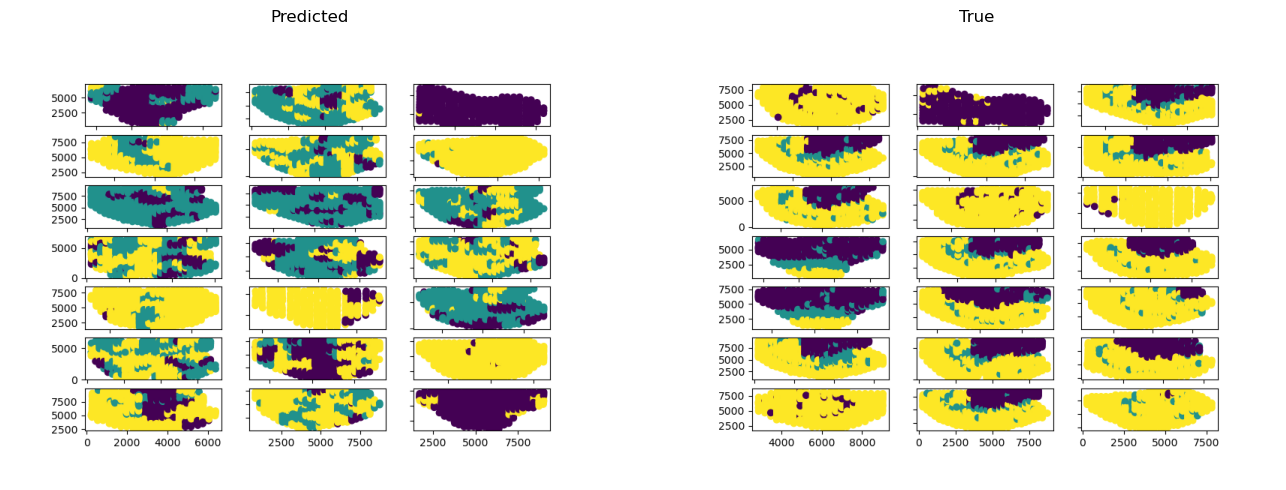

In [ ]:
plot_preds(model1, test_loader, device)

In [ ]:
plot_correct_preds(model1, test_loader, device)

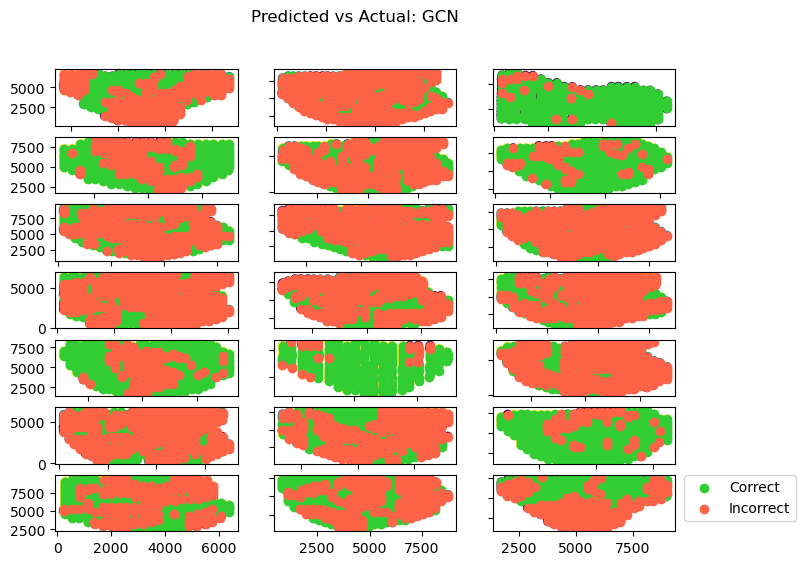

The GCN has a very low accuracy when factoring in balanced class weights. It seems to be predicting all 3 classes for the most part.

#### Evaluation: SpatialKernel

In [ ]:
preds, labels = evaluate_predictions(test_loader, model2)

Test accuracy: 66.14542611415169
Test F1: 55.06424786241638
Classification Report: 
              precision    recall  f1-score   support

           0       0.74      0.07      0.12      2447
           1       0.26      0.03      0.05      1149
           2       0.66      0.99      0.80      6636

    accuracy                           0.66     10232
   macro avg       0.55      0.36      0.32     10232
weighted avg       0.64      0.66      0.55     10232



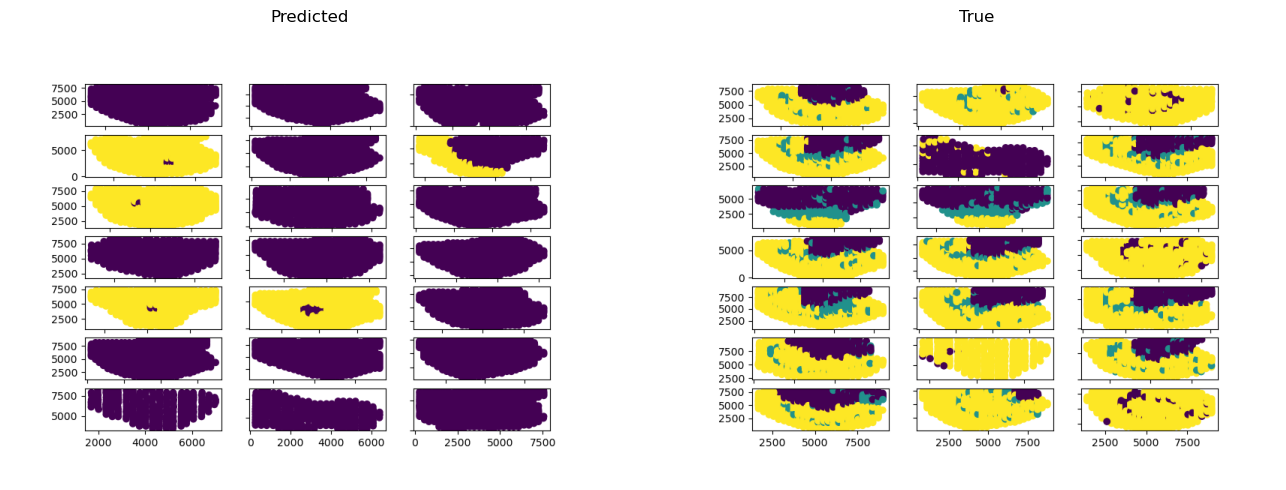

In [ ]:
plot_preds(model2, test_loader, device)

In [ ]:
plot_correct_preds(model2, test_loader, device)

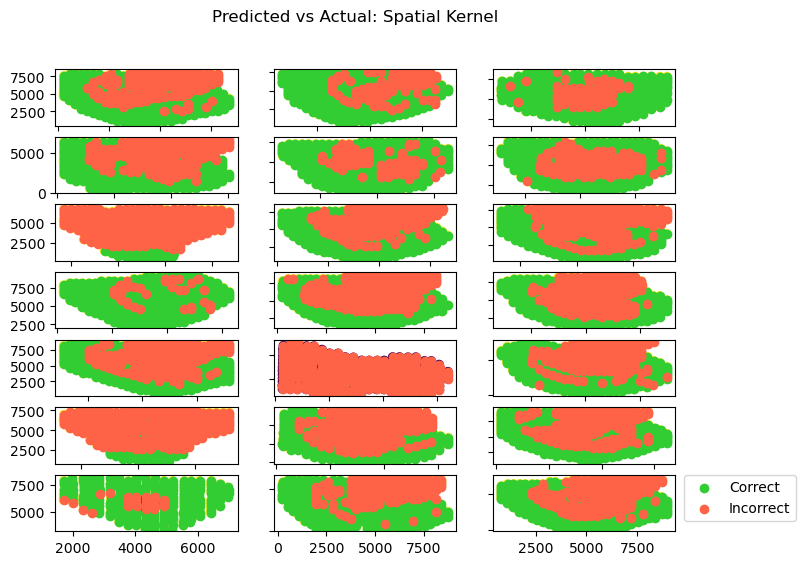

The SpatialKernel model is worse in accuracy to the GCN. It seems to be doing a better job than the GCN in generalizing across the classes.

#### Evaluation: SpatialGCN

In [ ]:
evaluate_predictions(val_loader, model3, val=True)
preds, labels = evaluate_predictions(test_loader, model3)

Validation accuracy: 60.872127283441365
Validation F1: 46.06659888922706
Test accuracy: 65.4319781078968
Test F1: 52.96785979831014
Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2447
           1       0.28      0.07      0.11      1149
           2       0.66      1.00      0.80      6636

    accuracy                           0.65     10232
   macro avg       0.31      0.36      0.30     10232
weighted avg       0.46      0.65      0.53     10232



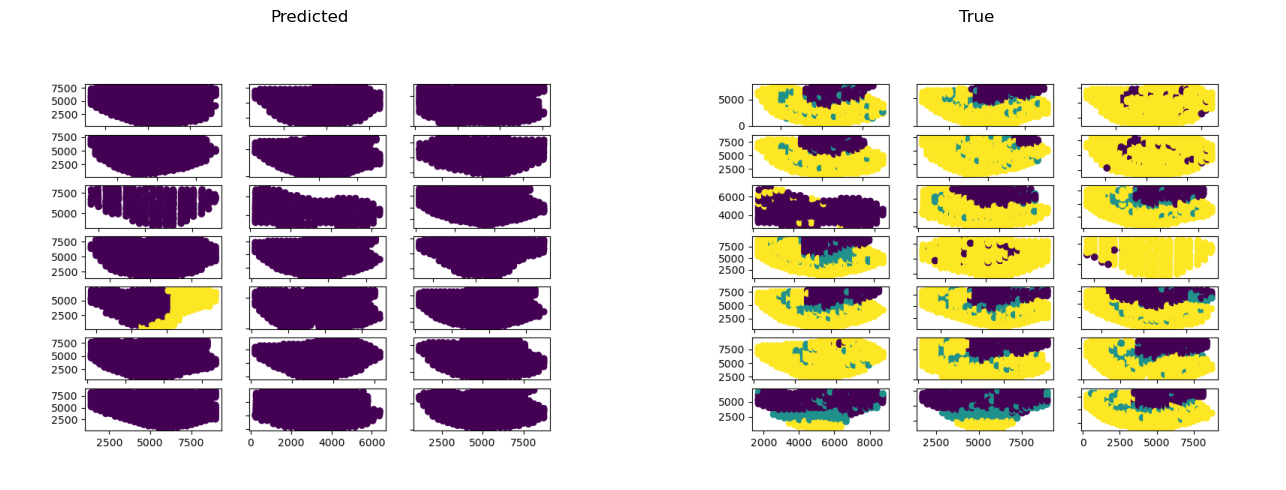

In [ ]:
plot_preds(model3, test_loader, device)

In [ ]:
plot_correct_preds(model3, test_loader, device)

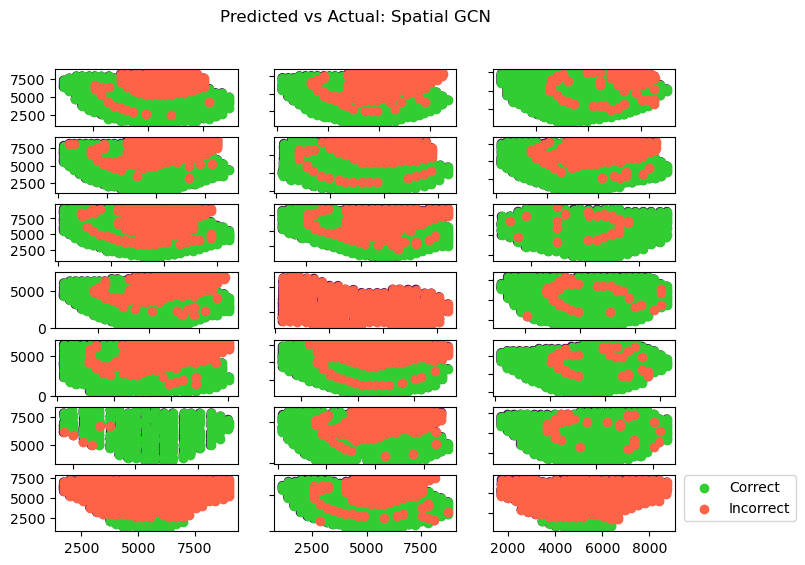

This model shows better accuracy than the previous two, however it is not predicting for the third class at all.

#### Evaluation: GraphPDE

In [ ]:
evaluate_predictions(val_loader, model4, val=True)
preds, labels = evaluate_predictions(test_loader, model4)

Validation accuracy: 69.09251620506777
Validation F1: 72.01030622842087
Test accuracy: 66.68295543393276
Test F1: 70.58421298841391
Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      2447
           1       0.15      0.32      0.20      1149
           2       0.91      0.68      0.78      6636

    accuracy                           0.67     10232
   macro avg       0.59      0.60      0.58     10232
weighted avg       0.77      0.67      0.71     10232



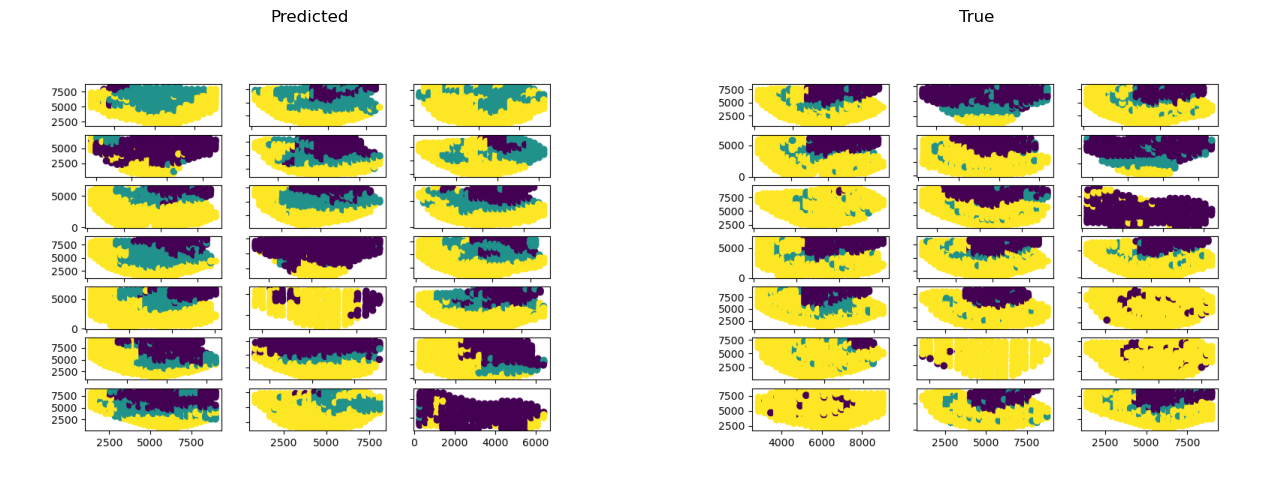

In [ ]:
plot_preds(model4, test_loader, device)

In [ ]:
plot_correct_preds(model4, test_loader, device)

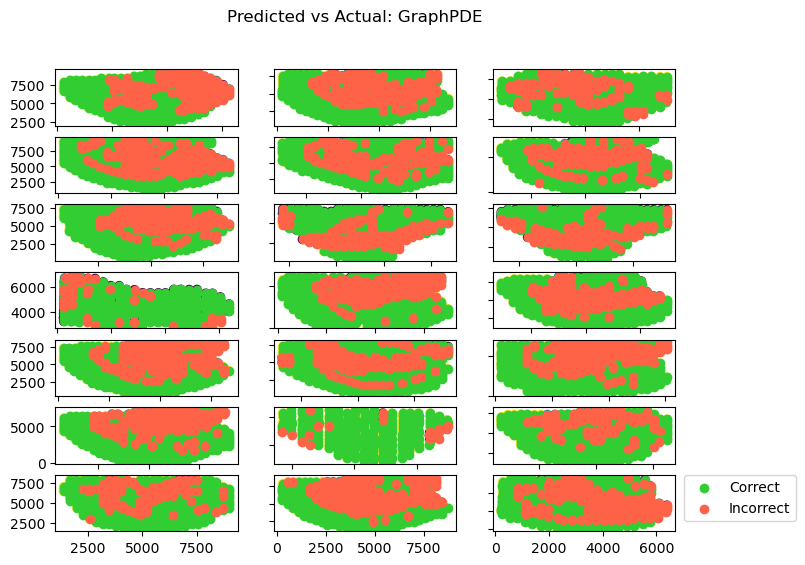

This model seems to be the most reliable both in terms of accuracy and generalization across classes. It has the highest reported accuracy than the other graph network methods. It is slightly better than the XGBoost model, which proved to be the best baseline.

#### Evaluation: GAT

In [ ]:
evaluate_predictions(val_loader, model5, val=True)
preds, labels = evaluate_predictions(test_loader, model5)

Validation accuracy: 43.07601649970536
Validation F1: 46.40804341202422
Test accuracy: 47.068021892103204
Test F1: 51.369579312168234
Classification Report: 
              precision    recall  f1-score   support

           0       0.41      0.46      0.43      2447
           1       0.11      0.30      0.17      1149
           2       0.75      0.51      0.60      6636

    accuracy                           0.47     10232
   macro avg       0.42      0.42      0.40     10232
weighted avg       0.60      0.47      0.51     10232



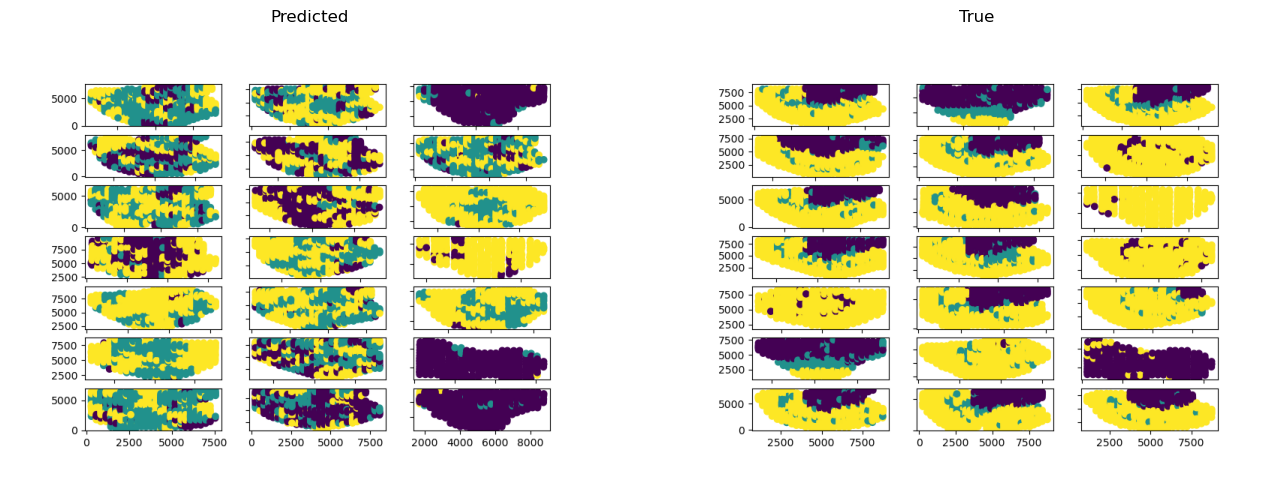

In [ ]:
plot_preds(model5, test_loader, device)

In [ ]:
plot_correct_preds(model5, test_loader, device)

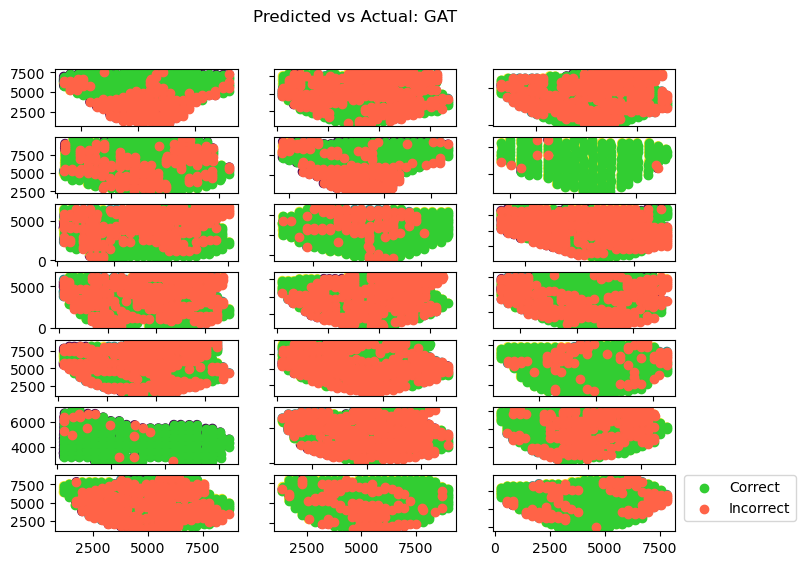

The graph attention network is not comparable to the top performers in terms of accuracy, nor is it predictive towards all three classes. Furthermore it takes longer to train, so it is not a worthy tradeoff.

#### Evaluation: GraphSAGE

In [ ]:
evaluate_predictions(val_loader, model6, val=True)
preds, labels = evaluate_predictions(test_loader, model6)

Validation accuracy: 36.859163229228045
Validation F1: 31.899229634130187
Test accuracy: 43.28577013291634
Test F1: 43.485276242205885
Classification Report: 
              precision    recall  f1-score   support

           0       0.33      0.87      0.48      2447
           1       0.11      0.12      0.11      1149
           2       0.86      0.33      0.47      6636

    accuracy                           0.43     10232
   macro avg       0.43      0.44      0.36     10232
weighted avg       0.65      0.43      0.43     10232



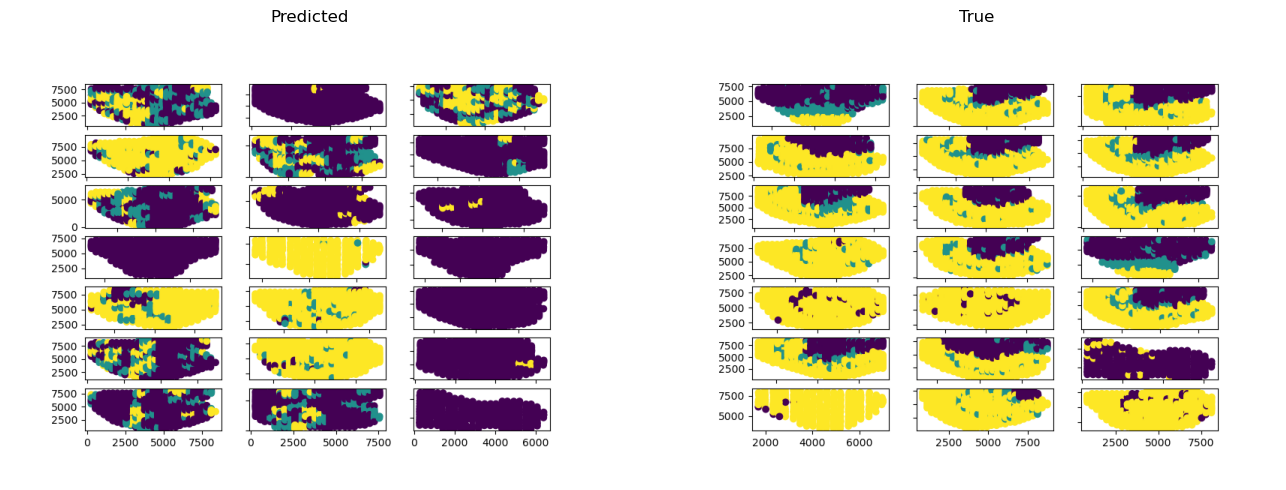

In [ ]:
plot_preds(model6, test_loader, device)

In [ ]:
plot_correct_preds(model6, test_loader, device)

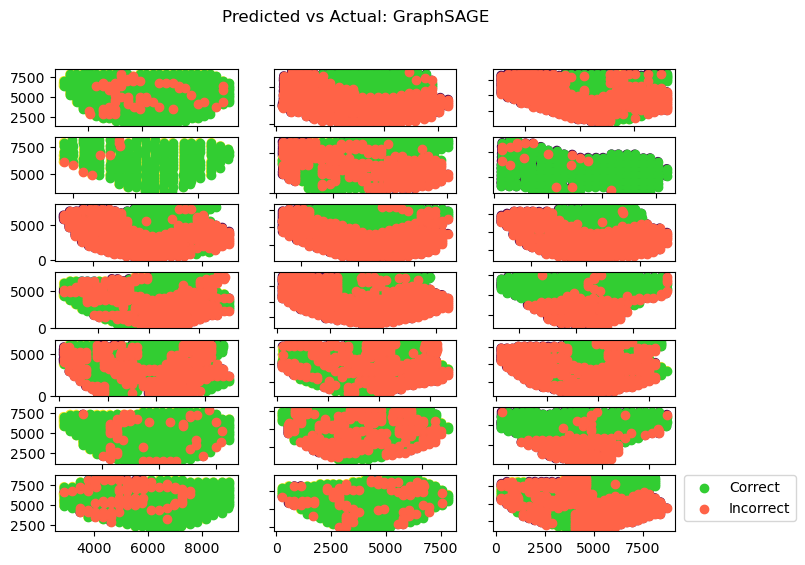

The GraphSAGE network performs worse than the attention network and slightly better than the simple spatial kernel model. It is not highly predictive towards all classes.

#### Evaluation: GIN

In [ ]:
evaluate_predictions(val_loader, model7, val=True)
preds, labels = evaluate_predictions(test_loader, model7)

Validation accuracy: 51.50265173836181
Validation F1: 52.11454990140366
Test accuracy: 55.033229085222835
Test F1: 55.44600315337177
Classification Report: 
              precision    recall  f1-score   support

           0       0.38      0.32      0.34      2447
           1       0.17      0.23      0.19      1149
           2       0.70      0.69      0.69      6636

    accuracy                           0.55     10232
   macro avg       0.41      0.41      0.41     10232
weighted avg       0.56      0.55      0.55     10232



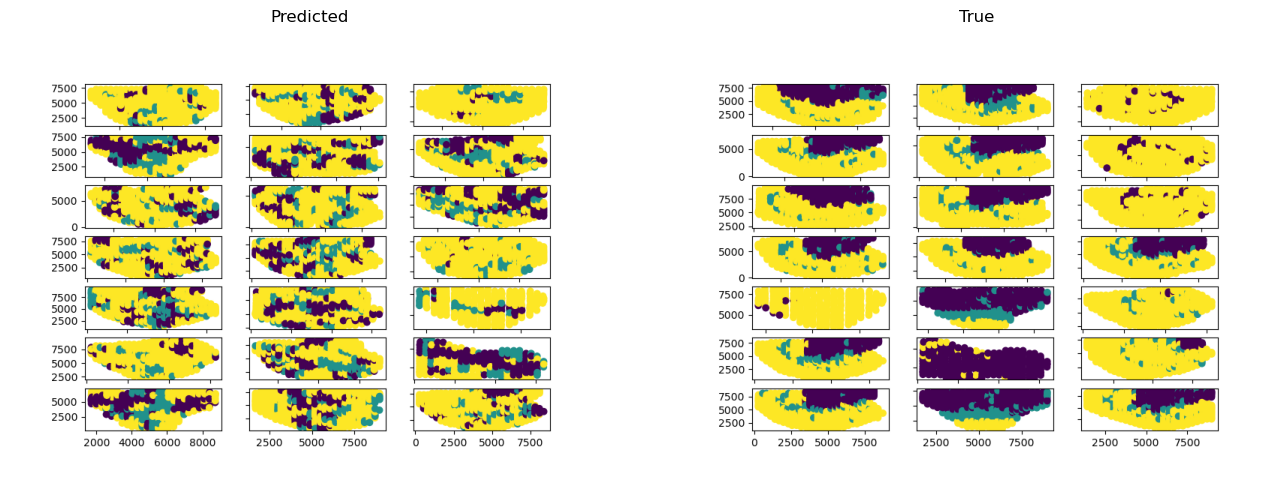

In [ ]:
plot_preds(model7, test_loader, device)

In [ ]:
plot_correct_preds(model7, test_loader, device)

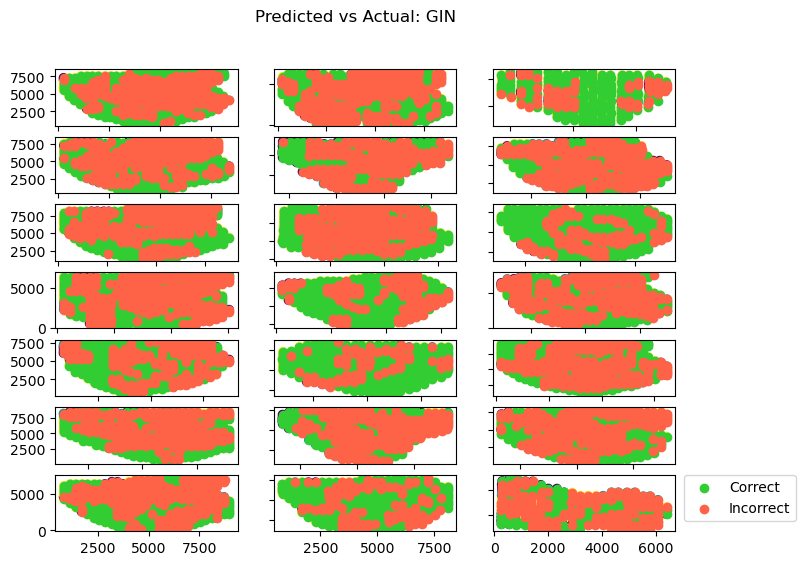

This network is more performant than the Graph Attention Network and the GraphSAGE networks and is comparable to the suite of actual graph baselines. It is more accurate than the GCN and the loss is minimal compared to other models. It lacks in terms of representation of all three classes, yet it is still a valid comparator against the graph neural operator.

## 6. Deployment

To deploy the best performing model, that being the graph kernel neural operator (GraphPDE), there are two potential routes I may consider. One is of inference, where the final weights of the trained model are exposed via a REST API. This will only provide inference to additional sample data for the mouse brain. The newly curated data may either be related to the initial mouse on which the model was trained, or collected from tissue sections across general mice. The final state of the  may have its weights saved to a .pt file. Then, an endpoint may be generated using either FastAPI for local serving or a cloud hosted API service such as AWS's Lambda. The endpoint can accept a POST request from the user consisting of new transcriptomics brain data, or there may be a separate service to ingest the new data, store it to a database, and call inference on the locally stored data using a GET request. Furthermore, in order for this service to scale, I may set up celery workers to handle inference asynchronously, and additionally I may consider using Kubernetes to auto-scale and provide load balancing.

The other route I may consider is of retraining or fine tuning. In this case, I would package the solution as a docker container with separate `exec` commands for either of retraining or fine tuning purposes. The user would be able to specify a new dataset to pass in as a parameter with a flag `--train` to the docker executable indicating it to train on the new set, or the user may specify a `--finetune` flag to fine tune the current state of the saved model with new data. This may be useful for handling data/concept drift.

## Conclusion and Takeaways

This study was a compelling endeavor in order to determine the efficacy of applying neural operators to learning of spatial information incorporating the use case of spatial transcriptomics. The application proved worthwhile and sets up neural operators as viable solutions for applying this approach across other variations of transcriptomics or possibly any other variation of spatial information collection. I believe this approach may be improved with better understanding and application of the inherent parameters, possibly even with a transformer/attention based inherent architecture, as well as with better generalization with inclusion of data across multiple mice. Furthermore, I think application on a human brain or other organ set would prove noteworthy in a pipeline model solution for differential diagnosis of disease classification.